In [1]:
import numpy as np 
import pandas as pd # ( pd.read_csv)
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report,cohen_kappa_score
import os, gensim, copy, pickle, warnings
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
import numpy as np
from gensim import corpora, models
import seaborn as sns
np.random.seed(400)
from imblearn.over_sampling import SMOTE
import pyLDAvis
import pyLDAvis.gensim_models
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/daisy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/daisy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
features = pd.read_csv('data/features.csv')
labels = pd.read_csv('data/labels.csv')
# test = pd.read_csv('data/test.csv')

### Check basic information

### Need to match the trackID to get the label for features, assuming “classic pop and rock” is different from pop

In [3]:
all_data = features.merge(labels, on=['trackID'], how='inner')
print(len(all_data),'combined data length \n', 
      len(features), 'feature length \n', 
      len(labels), 'label length')

8128 combined data length 
 8128 feature length 
 8128 label length


# Step 1: Exploratory Data Analyse and preprocessing

### The tag and title are all strings, need to convert to list and dict

In [4]:
## pre-processing by split the tag and title to list
def combine_title_and_tags(df):
    combine_title_tag_list = []
    for i in range(len(df)):
        df['title'] = df['title'].fillna('')
        df['tags'] = df['tags'].fillna('')
        combine_title_tag_list.append(" ".join([df['title'][i],df['tags'][i]]))   
    df = df.assign(text = pd.Series(combine_title_tag_list))
    df = df.drop(columns = ['tags','title'])
    return df
all_data = combine_title_and_tags(all_data)

### Imbalanced dataset, but not extremely imbalanced

# Step2: Preprocessing and prepare for modelling

In [5]:
## Split to train and test
y = all_data.pop('genre')
X_train, X_valid, y_train, y_valid = train_test_split( all_data, y, test_size=0.4, random_state=15, stratify=y)

In [6]:
print(np.shape(X_train))
X_valid= X_valid.reset_index(drop=True)
y_valid= y_valid.reset_index(drop=True)
X_valid.to_csv('test/X_valid.csv')
y_valid.to_csv('test/y_valid.csv')
X_train.to_csv('test/X_train.csv')
y_train.to_csv('test/y_train.csv')

(4876, 156)


## Check text data

In [7]:
X_train_text2 = pd.DataFrame(X_train.reset_index(drop=True))
y_train_text2 = y_train.reset_index(drop=True)

In [8]:
stop_words = stopwords.words('english')
stop_words.extend(['let','oh','hey', 'hay', 'ya', 'ooh',  'go', 'ai', 'tell',
                   'ca', 'na', 'say', 'sure', 'yeah', 'tu', 'els', 'might', 'done']) #'may','day'

def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def lemmatize_stemming_2(texts):
    all_output =[]
    for j in texts:
         all_output.append([WordNetLemmatizer().lemmatize(i, pos = 'v') for i in j])
    return all_output


def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def get_corpus(df):
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = lemmatize_stemming_2(words) ##new
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=12, no_above=0.5)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

## create vectors
def get_text_vector(df, corpuss, lda_model):
    vecs = []
    for i in range(len(df)):
        top_topics = lda_model.get_document_topics(corpuss[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(8)]
        topic_vec.extend([len(df.iloc[i].text)]) # length review
        vecs.append(topic_vec)
    return vecs



In [9]:
X_train_text2.columns

Index(['trackID', 'loudness', 'tempo', 'time_signature', 'key', 'mode',
       'duration', 'vect_1', 'vect_2', 'vect_3',
       ...
       'vect_140', 'vect_141', 'vect_142', 'vect_143', 'vect_144', 'vect_145',
       'vect_146', 'vect_147', 'vect_148', 'text'],
      dtype='object', length=156)

In [10]:
train_corpus, train_id2word, bigram_train = get_corpus(X_train_text2)

with open('model/train_corpus.pkl', 'wb') as f:
    pickle.dump(train_corpus, f)
with open('model/train_id2word.pkl', 'wb') as f:
    pickle.dump(train_id2word, f)
with open('model/bigram_train.pkl', 'wb') as f:
    pickle.dump(bigram_train, f)

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_model = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=8,
                           id2word=train_id2word,
                           chunksize=20,
                           workers=7, 
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_model.save('model/lda_model.model')

In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, train_corpus, train_id2word , mds="mmds", R=30)
vis

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.046948  0.108976       1        1  35.097244
1      0.138495  0.283173       2        1  26.635692
3      0.325109  0.156742       3        1  16.955197
2      0.324659 -0.185555       4        1   7.030046
6     -0.295914 -0.352731       5        1   5.535843
0     -0.208701  0.332909       6        1   3.380548
7      0.073230 -0.356716       7        1   3.116599
5     -0.403826  0.013203       8        1   2.248831, topic_info=           Term        Freq       Total Category  logprob  loglift
16         love  991.000000  991.000000  Default  30.0000  30.0000
78          get  833.000000  833.000000  Default  29.0000  29.0000
85    love_know  959.000000  959.000000  Default  28.0000  28.0000
232      que_de  311.000000  311.000000  Default  27.0000  27.0000
362       la_en  207.000000  207.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1087         si   44.795707   49.286503   Topic8  -4.6373   3.6992
876       grave   50.023234   74.701169   Topic8  -4.5269   3.3938
1126         ne   48.756513   75.706244   Topic8  -4.5526   3.3547
2677         ha   44.587255   84.091606   Topic8  -4.6420   3.1603
1488     choose   37.114455   53.770400   Topic8  -4.8254   3.4240

[466 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
710       2  0.922112     across
710       3  0.071853     across
1847      6  0.968333  afternoon
0         1  0.142845        air
0         2  0.747557        air
...     ...       ...        ...
1008      2  0.091891        yes
1731      5  0.337170         yo
1731      7  0.646243         yo
2599      5  0.992189      yo_si
34        4  0.990036       york

[720 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 7, 1, 8, 6])

It seems there are some overlaps between topic 1 and 2

There are a few words seems to be stop words but not in the stop words list, added the extra stop words like ['hey', 'hay', 'ya','ooh'] to the existing stop words dictionary

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_model2 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=16,
                           id2word=train_id2word,
                           chunksize=50,
                           workers=7, 
                           passes=100,
                           eval_every = 1,
                           per_word_topics=False)
    lda_model2.save('model/lda_model2.model')


In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model2, train_corpus, train_id2word , mds="mmds", R=30)
vis

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.211991 -0.031163       1        1  29.944420
14     0.272869 -0.196212       2        1  17.163738
15     0.372266 -0.150210       3        1  15.841280
0      0.393415  0.032973       4        1  10.598518
5      0.310396  0.203886       5        1   7.673606
6      0.152255 -0.393095       6        1   3.652476
13    -0.437301 -0.238828       7        1   3.390012
7     -0.029854 -0.274569       8        1   2.344583
12    -0.037357  0.074803       9        1   2.000180
1     -0.455718  0.063515      10        1   1.560351
2      0.008237  0.420076      11        1   1.198851
11    -0.190386 -0.418261      12        1   1.083997
3      0.194632  0.352310      13        1   0.915516
4     -0.171045  0.378447      14        1   0.884910
9     -0.319085  0.237271      15        1   0.875926
10    -0.275315 -0.060944      16        1   0.871636, topic_info=           Term        Freq       Total Category  logprob  loglift
232      que_de  317.000000  317.000000  Default  30.0000  30.0000
85    love_know  955.000000  955.000000  Default  29.0000  29.0000
66          die  251.000000  251.000000  Default  28.0000  28.0000
78          get  874.000000  874.000000  Default  27.0000  27.0000
406       think  971.000000  971.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1572         al   23.169401   67.077244  Topic16  -4.3488   3.6795
1726       noch   22.660290   62.777127  Topic16  -4.3710   3.7236
1061        dem   22.151574   74.111642  Topic16  -4.3937   3.5349
201         war   25.031007  190.051932  Topic16  -4.2715   2.7154
81          hat   20.792704   49.563898  Topic16  -4.4570   3.8739

[878 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3015     14  0.929959    abandon
70       16  0.968628       ador
2111     11  0.966714      advic
2917      8  0.934003     affair
1847      3  0.968846  afternoon
...     ...       ...        ...
2587      5  0.971089         ye
2140     16  0.974271        yeh
2210      4  0.981785     yellow
2599      7  0.988830      yo_si
1098     15  0.962820        yuh

[1542 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 15, 16, 1, 6, 7, 14, 8, 13, 2, 3, 12, 4, 5, 10, 11])

### Check topic and key words example

In [15]:
lda_model.print_topics(8,num_words=15)[:12]

[(0,
  '0.016*"love" + 0.016*"wild" + 0.011*"man_give" + 0.009*"winter" + 0.008*"alway" + 0.008*"mind_wo" + 0.008*"guy" + 0.007*"woman" + 0.007*"tiempo" + 0.007*"harder" + 0.007*"like" + 0.006*"fire" + 0.006*"higher" + 0.006*"still_girl" + 0.006*"anywher"'),
 (1,
  '0.009*"come" + 0.006*"love" + 0.005*"see" + 0.005*"hear" + 0.004*"sea" + 0.004*"make" + 0.004*"find" + 0.004*"fli" + 0.004*"light" + 0.004*"sing" + 0.004*"shine" + 0.004*"sun" + 0.004*"like" + 0.004*"know" + 0.004*"night"'),
 (2,
  '0.012*"get" + 0.011*"money" + 0.011*"drink" + 0.009*"shit" + 0.008*"fuck" + 0.007*"roll" + 0.007*"parti" + 0.006*"street" + 0.006*"one_get" + 0.006*"shoot" + 0.006*"buy" + 0.006*"car" + 0.006*"check" + 0.006*"head" + 0.006*"kid"'),
 (3,
  '0.007*"blood" + 0.005*"burn" + 0.005*"tear" + 0.005*"death" + 0.005*"break" + 0.005*"take" + 0.005*"fire" + 0.005*"world" + 0.005*"eye" + 0.005*"live" + 0.005*"life" + 0.004*"hell" + 0.004*"god" + 0.004*"bear" + 0.004*"fight"'),
 (4,
  '0.013*"love_know" + 0.0

In [16]:
train_vecs1 = get_text_vector(X_train_text2, train_corpus, lda_model)
train_vecs2 = get_text_vector(X_train_text2, train_corpus, lda_model2)



In [17]:
print(np.shape(train_vecs2 ))
train_vecs = np.concatenate([train_vecs1, train_vecs2], axis=1)
np.shape(train_vecs)

(4876, 9)


(4876, 18)

In [18]:
### to continue
X = np.array(train_vecs)
y = np.array(y_train_text2)

In [19]:
## simulate minority groups
def smote2(X, y):
    X1, y1 = copy.deepcopy(X), copy.deepcopy(y)  # init
    sm = SMOTE(random_state=2)
    X1, y1 = sm.fit_resample(X, y)
    return X1, y1

X2,y2 = smote2(X,y)

### prepare for test text vec

In [20]:
def get_bigram(df):
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[i] for i in words]
    return bigram

def prepare_text_for_prediction(X_text_df, y_text_df, id2word_dict,lda_model):
    bigram_df = get_bigram(X_text_df)
    df_corpus = [id2word_dict.doc2bow(text) for text in bigram_df]
    df_vecs = get_text_vector(X_text_df, df_corpus, lda_model)
    X_text_array = np.array(df_vecs)
    y_text_array = np.array(y_text_df)
    return X_text_array, y_text_array



In [21]:
del lda_model, train_id2word, train_corpus, bigram_train

lda_model = gensim.models.ldamulticore.LdaMulticore.load('model/lda_model.model')
train_id2word =  pickle.load(open("model/train_id2word.pkl", 'rb'))
lda_model2 = gensim.models.ldamulticore.LdaMulticore.load('model/lda_model2.model')

In [22]:
X_text_array1, y_text_array1 = prepare_text_for_prediction(X_valid, y_valid, train_id2word,lda_model)
X_text_array2, y_text_array2 = prepare_text_for_prediction(X_valid, y_valid, train_id2word,lda_model2)

In [23]:
valid_vecs = np.concatenate([X_text_array1, X_text_array2], axis=1)
X_valid_vecs = np.array(valid_vecs)
valid_y= np.array(y_valid)

In [24]:
np.shape(X_valid_vecs) , np.shape(y_valid)

((3252, 18), (3252,))

In [25]:
X_valid_text_vec2, X_test_text_vec2, y_valid2, y_test2 = train_test_split(X_valid_vecs , y_valid, test_size=0.5, random_state=123)


# Step 3: modelling 

In [26]:
def grid_search_CV(grid_para, X, y, test_X, test_y):

    model_1 = GridSearchCV(XGBClassifier(eval_metric='mlogloss'),
                               grid_para, cv=3)
    model_1.fit(X, y, eval_set = [(test_X, test_y)],
                early_stopping_rounds = 10)
    print(model_1.best_score_)
    print(model_1.best_params_)
    
    {'colsample_bytree': 0.5, 'eta': 0.15, 'gamma': 0.15, 'max_depth': 7, 'num_parallel_tree': 5, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'sampling_method': 'gradient_based'}
    {'colsample_bytree': 0.5, 'eta': 0.1, 'gamma': 0.15, 'max_depth': 7, 'num_parallel_tree': 5, 'reg_alpha': 0.6, 'reg_lambda': 0.1, 'sampling_method': 'gradient_based'}
    {'colsample_bytree': 0.5, 'eta': 0.1, 'gamma': 0.1, 'max_depth': 7, 'num_parallel_tree': 5, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'sampling_method': 'gradient_based'}

    xgb_m = XGBClassifier(eval_metric = ['mlogloss'],
                          objective='multi:softprob',
                          booster = 'gbtree',
                          grow_policy='lossguide',
                          max_depth=model_1.best_params_['max_depth'],
                          reg_alpha=model_1.best_params_['reg_alpha'],
                          reg_lambda=model_1.best_params_['reg_lambda'],
                          eta=model_1.best_params_['eta'],
                          num_parallel_tree = model_1.best_params_['num_parallel_tree'],
                          gamma=model_1.best_params_['gamma'],
                          sampling_method=model_1.best_params_['sampling_method'],
                          colsample_bytree=model_1.best_params_['colsample_bytree'],
                          seed=123,
                          n_jobs = -1,
                            )
    xgb_m.fit(X, y)
    xgb_m.save_model('model/xgb_model_text.model')
    return  xgb_m

In [27]:

max_depth = [7, 5]  #5, 
eta = [.1, .15]  
gamma = [.15, .2] 
sampling_method = ['gradient_based']  
reg_lambda = [.1, .15]
colsample_bytree = [.4, .5] 
alphax = [.6, .5] 
num_parallel_tree = [5] 
grid_para_2 = dict(max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=alphax,
                 colsample_bytree=colsample_bytree, eta=eta, gamma=gamma,
                 sampling_method=sampling_method, 
                 num_parallel_tree=num_parallel_tree)
xgb_model = grid_search_CV(grid_para_2, X2, y2, X_valid_text_vec2, y_valid2) #

[0]	validation_0-mlogloss:2.02027


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97335
[2]	validation_0-mlogloss:1.93291
[3]	validation_0-mlogloss:1.90142
[4]	validation_0-mlogloss:1.87358
[5]	validation_0-mlogloss:1.84683
[6]	validation_0-mlogloss:1.82428
[7]	validation_0-mlogloss:1.80493
[8]	validation_0-mlogloss:1.78442
[9]	validation_0-mlogloss:1.76795
[10]	validation_0-mlogloss:1.75317
[11]	validation_0-mlogloss:1.73966
[12]	validation_0-mlogloss:1.72835
[13]	validation_0-mlogloss:1.71641
[14]	validation_0-mlogloss:1.70622
[15]	validation_0-mlogloss:1.69711
[16]	validation_0-mlogloss:1.68868
[17]	validation_0-mlogloss:1.68051
[18]	validation_0-mlogloss:1.67346
[19]	validation_0-mlogloss:1.66767
[20]	validation_0-mlogloss:1.66186
[21]	validation_0-mlogloss:1.65673
[22]	validation_0-mlogloss:1.65172
[23]	validation_0-mlogloss:1.64728
[24]	validation_0-mlogloss:1.64297
[25]	validation_0-mlogloss:1.63889
[26]	validation_0-mlogloss:1.63574
[27]	validation_0-mlogloss:1.63207
[28]	validation_0-mlogloss:1.63008
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97905
[2]	validation_0-mlogloss:1.94065
[3]	validation_0-mlogloss:1.90985
[4]	validation_0-mlogloss:1.88375
[5]	validation_0-mlogloss:1.85782
[6]	validation_0-mlogloss:1.83586
[7]	validation_0-mlogloss:1.81780
[8]	validation_0-mlogloss:1.79802
[9]	validation_0-mlogloss:1.78209
[10]	validation_0-mlogloss:1.76830
[11]	validation_0-mlogloss:1.75472
[12]	validation_0-mlogloss:1.74319
[13]	validation_0-mlogloss:1.73175
[14]	validation_0-mlogloss:1.72177
[15]	validation_0-mlogloss:1.71232
[16]	validation_0-mlogloss:1.70338
[17]	validation_0-mlogloss:1.69562
[18]	validation_0-mlogloss:1.68885
[19]	validation_0-mlogloss:1.68290
[20]	validation_0-mlogloss:1.67670
[21]	validation_0-mlogloss:1.67123
[22]	validation_0-mlogloss:1.66605
[23]	validation_0-mlogloss:1.66146
[24]	validation_0-mlogloss:1.65725
[25]	validation_0-mlogloss:1.65330
[26]	validation_0-mlogloss:1.64989
[27]	validation_0-mlogloss:1.64646
[28]	validation_0-mlogloss:1.64372
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98441
[2]	validation_0-mlogloss:1.94780
[3]	validation_0-mlogloss:1.91765
[4]	validation_0-mlogloss:1.89328
[5]	validation_0-mlogloss:1.86740
[6]	validation_0-mlogloss:1.84592
[7]	validation_0-mlogloss:1.82865
[8]	validation_0-mlogloss:1.81073
[9]	validation_0-mlogloss:1.79488
[10]	validation_0-mlogloss:1.78070
[11]	validation_0-mlogloss:1.76832
[12]	validation_0-mlogloss:1.75743
[13]	validation_0-mlogloss:1.74636
[14]	validation_0-mlogloss:1.73661
[15]	validation_0-mlogloss:1.72741
[16]	validation_0-mlogloss:1.71849
[17]	validation_0-mlogloss:1.71048
[18]	validation_0-mlogloss:1.70409
[19]	validation_0-mlogloss:1.69790
[20]	validation_0-mlogloss:1.69223
[21]	validation_0-mlogloss:1.68652
[22]	validation_0-mlogloss:1.68123
[23]	validation_0-mlogloss:1.67629
[24]	validation_0-mlogloss:1.67172
[25]	validation_0-mlogloss:1.66797
[26]	validation_0-mlogloss:1.66465
[27]	validation_0-mlogloss:1.66081
[28]	validation_0-mlogloss:1.65807
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97378
[2]	validation_0-mlogloss:1.93306
[3]	validation_0-mlogloss:1.90164
[4]	validation_0-mlogloss:1.87394
[5]	validation_0-mlogloss:1.84720
[6]	validation_0-mlogloss:1.82471
[7]	validation_0-mlogloss:1.80546
[8]	validation_0-mlogloss:1.78485
[9]	validation_0-mlogloss:1.76828
[10]	validation_0-mlogloss:1.75364
[11]	validation_0-mlogloss:1.74024
[12]	validation_0-mlogloss:1.72903
[13]	validation_0-mlogloss:1.71701
[14]	validation_0-mlogloss:1.70675
[15]	validation_0-mlogloss:1.69786
[16]	validation_0-mlogloss:1.68939
[17]	validation_0-mlogloss:1.68113
[18]	validation_0-mlogloss:1.67400
[19]	validation_0-mlogloss:1.66821
[20]	validation_0-mlogloss:1.66233
[21]	validation_0-mlogloss:1.65727
[22]	validation_0-mlogloss:1.65225
[23]	validation_0-mlogloss:1.64801
[24]	validation_0-mlogloss:1.64373
[25]	validation_0-mlogloss:1.63972
[26]	validation_0-mlogloss:1.63671
[27]	validation_0-mlogloss:1.63301
[28]	validation_0-mlogloss:1.63089
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.97907
[2]	validation_0-mlogloss:1.94056
[3]	validation_0-mlogloss:1.90988
[4]	validation_0-mlogloss:1.88374
[5]	validation_0-mlogloss:1.85776
[6]	validation_0-mlogloss:1.83577
[7]	validation_0-mlogloss:1.81800
[8]	validation_0-mlogloss:1.79842
[9]	validation_0-mlogloss:1.78236
[10]	validation_0-mlogloss:1.76870
[11]	validation_0-mlogloss:1.75520
[12]	validation_0-mlogloss:1.74353
[13]	validation_0-mlogloss:1.73219
[14]	validation_0-mlogloss:1.72200
[15]	validation_0-mlogloss:1.71277
[16]	validation_0-mlogloss:1.70417
[17]	validation_0-mlogloss:1.69655
[18]	validation_0-mlogloss:1.68968
[19]	validation_0-mlogloss:1.68352
[20]	validation_0-mlogloss:1.67753
[21]	validation_0-mlogloss:1.67195
[22]	validation_0-mlogloss:1.66658
[23]	validation_0-mlogloss:1.66180
[24]	validation_0-mlogloss:1.65752
[25]	validation_0-mlogloss:1.65353
[26]	validation_0-mlogloss:1.65029
[27]	validation_0-mlogloss:1.64670
[28]	validation_0-mlogloss:1.64421
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98455
[2]	validation_0-mlogloss:1.94810
[3]	validation_0-mlogloss:1.91791
[4]	validation_0-mlogloss:1.89360
[5]	validation_0-mlogloss:1.86796
[6]	validation_0-mlogloss:1.84629
[7]	validation_0-mlogloss:1.82876
[8]	validation_0-mlogloss:1.81077
[9]	validation_0-mlogloss:1.79471
[10]	validation_0-mlogloss:1.78049
[11]	validation_0-mlogloss:1.76806
[12]	validation_0-mlogloss:1.75721
[13]	validation_0-mlogloss:1.74624
[14]	validation_0-mlogloss:1.73647
[15]	validation_0-mlogloss:1.72710
[16]	validation_0-mlogloss:1.71825
[17]	validation_0-mlogloss:1.71030
[18]	validation_0-mlogloss:1.70396
[19]	validation_0-mlogloss:1.69792
[20]	validation_0-mlogloss:1.69208
[21]	validation_0-mlogloss:1.68656
[22]	validation_0-mlogloss:1.68134
[23]	validation_0-mlogloss:1.67615
[24]	validation_0-mlogloss:1.67169
[25]	validation_0-mlogloss:1.66798
[26]	validation_0-mlogloss:1.66469
[27]	validation_0-mlogloss:1.66108
[28]	validation_0-mlogloss:1.65867
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02000
[1]	validation_0-mlogloss:1.97287
[2]	validation_0-mlogloss:1.93219
[3]	validation_0-mlogloss:1.90094
[4]	validation_0-mlogloss:1.87282
[5]	validation_0-mlogloss:1.84575
[6]	validation_0-mlogloss:1.82308
[7]	validation_0-mlogloss:1.80371
[8]	validation_0-mlogloss:1.78293
[9]	validation_0-mlogloss:1.76650
[10]	validation_0-mlogloss:1.75170
[11]	validation_0-mlogloss:1.73837
[12]	validation_0-mlogloss:1.72719
[13]	validation_0-mlogloss:1.71514
[14]	validation_0-mlogloss:1.70492
[15]	validation_0-mlogloss:1.69591
[16]	validation_0-mlogloss:1.68747
[17]	validation_0-mlogloss:1.67914
[18]	validation_0-mlogloss:1.67217
[19]	validation_0-mlogloss:1.66657
[20]	validation_0-mlogloss:1.66089
[21]	validation_0-mlogloss:1.65582
[22]	validation_0-mlogloss:1.65078
[23]	validation_0-mlogloss:1.64624
[24]	validation_0-mlogloss:1.64190
[25]	validation_0-mlogloss:1.63796
[26]	validation_0-mlogloss:1.63501
[27]	validation_0-mlogloss:1.63121
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02364
[1]	validation_0-mlogloss:1.97910
[2]	validation_0-mlogloss:1.94073
[3]	validation_0-mlogloss:1.91025
[4]	validation_0-mlogloss:1.88421
[5]	validation_0-mlogloss:1.85836
[6]	validation_0-mlogloss:1.83642
[7]	validation_0-mlogloss:1.81848
[8]	validation_0-mlogloss:1.79904
[9]	validation_0-mlogloss:1.78343
[10]	validation_0-mlogloss:1.76967
[11]	validation_0-mlogloss:1.75597
[12]	validation_0-mlogloss:1.74429
[13]	validation_0-mlogloss:1.73285
[14]	validation_0-mlogloss:1.72256
[15]	validation_0-mlogloss:1.71315
[16]	validation_0-mlogloss:1.70435
[17]	validation_0-mlogloss:1.69627
[18]	validation_0-mlogloss:1.68940
[19]	validation_0-mlogloss:1.68330
[20]	validation_0-mlogloss:1.67698
[21]	validation_0-mlogloss:1.67135
[22]	validation_0-mlogloss:1.66610
[23]	validation_0-mlogloss:1.66108
[24]	validation_0-mlogloss:1.65682
[25]	validation_0-mlogloss:1.65279
[26]	validation_0-mlogloss:1.64968
[27]	validation_0-mlogloss:1.64603
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98424
[2]	validation_0-mlogloss:1.94775
[3]	validation_0-mlogloss:1.91742
[4]	validation_0-mlogloss:1.89307
[5]	validation_0-mlogloss:1.86705
[6]	validation_0-mlogloss:1.84560
[7]	validation_0-mlogloss:1.82813
[8]	validation_0-mlogloss:1.80992
[9]	validation_0-mlogloss:1.79403
[10]	validation_0-mlogloss:1.78011
[11]	validation_0-mlogloss:1.76757
[12]	validation_0-mlogloss:1.75677
[13]	validation_0-mlogloss:1.74613
[14]	validation_0-mlogloss:1.73650
[15]	validation_0-mlogloss:1.72730
[16]	validation_0-mlogloss:1.71847
[17]	validation_0-mlogloss:1.71030
[18]	validation_0-mlogloss:1.70371
[19]	validation_0-mlogloss:1.69792
[20]	validation_0-mlogloss:1.69219
[21]	validation_0-mlogloss:1.68649
[22]	validation_0-mlogloss:1.68130
[23]	validation_0-mlogloss:1.67637
[24]	validation_0-mlogloss:1.67178
[25]	validation_0-mlogloss:1.66808
[26]	validation_0-mlogloss:1.66504
[27]	validation_0-mlogloss:1.66113
[28]	validation_0-mlogloss:1.65876
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02018
[1]	validation_0-mlogloss:1.97324
[2]	validation_0-mlogloss:1.93288
[3]	validation_0-mlogloss:1.90150
[4]	validation_0-mlogloss:1.87347
[5]	validation_0-mlogloss:1.84658
[6]	validation_0-mlogloss:1.82383
[7]	validation_0-mlogloss:1.80458
[8]	validation_0-mlogloss:1.78391
[9]	validation_0-mlogloss:1.76741
[10]	validation_0-mlogloss:1.75252
[11]	validation_0-mlogloss:1.73918
[12]	validation_0-mlogloss:1.72784
[13]	validation_0-mlogloss:1.71586
[14]	validation_0-mlogloss:1.70560
[15]	validation_0-mlogloss:1.69655
[16]	validation_0-mlogloss:1.68805
[17]	validation_0-mlogloss:1.67988
[18]	validation_0-mlogloss:1.67273
[19]	validation_0-mlogloss:1.66702
[20]	validation_0-mlogloss:1.66127
[21]	validation_0-mlogloss:1.65622
[22]	validation_0-mlogloss:1.65118
[23]	validation_0-mlogloss:1.64691
[24]	validation_0-mlogloss:1.64257
[25]	validation_0-mlogloss:1.63863
[26]	validation_0-mlogloss:1.63547
[27]	validation_0-mlogloss:1.63173
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02406
[1]	validation_0-mlogloss:1.97926
[2]	validation_0-mlogloss:1.94083
[3]	validation_0-mlogloss:1.91023
[4]	validation_0-mlogloss:1.88420
[5]	validation_0-mlogloss:1.85842
[6]	validation_0-mlogloss:1.83652
[7]	validation_0-mlogloss:1.81851
[8]	validation_0-mlogloss:1.79894
[9]	validation_0-mlogloss:1.78303
[10]	validation_0-mlogloss:1.76938
[11]	validation_0-mlogloss:1.75562
[12]	validation_0-mlogloss:1.74407
[13]	validation_0-mlogloss:1.73291
[14]	validation_0-mlogloss:1.72282
[15]	validation_0-mlogloss:1.71338
[16]	validation_0-mlogloss:1.70462
[17]	validation_0-mlogloss:1.69669
[18]	validation_0-mlogloss:1.68989
[19]	validation_0-mlogloss:1.68369
[20]	validation_0-mlogloss:1.67716
[21]	validation_0-mlogloss:1.67127
[22]	validation_0-mlogloss:1.66600
[23]	validation_0-mlogloss:1.66103
[24]	validation_0-mlogloss:1.65676
[25]	validation_0-mlogloss:1.65271
[26]	validation_0-mlogloss:1.64927
[27]	validation_0-mlogloss:1.64585
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98419
[2]	validation_0-mlogloss:1.94764
[3]	validation_0-mlogloss:1.91735
[4]	validation_0-mlogloss:1.89286
[5]	validation_0-mlogloss:1.86677
[6]	validation_0-mlogloss:1.84507
[7]	validation_0-mlogloss:1.82770
[8]	validation_0-mlogloss:1.80949
[9]	validation_0-mlogloss:1.79361
[10]	validation_0-mlogloss:1.77927
[11]	validation_0-mlogloss:1.76675
[12]	validation_0-mlogloss:1.75599
[13]	validation_0-mlogloss:1.74510
[14]	validation_0-mlogloss:1.73533
[15]	validation_0-mlogloss:1.72613
[16]	validation_0-mlogloss:1.71739
[17]	validation_0-mlogloss:1.70929
[18]	validation_0-mlogloss:1.70274
[19]	validation_0-mlogloss:1.69672
[20]	validation_0-mlogloss:1.69094
[21]	validation_0-mlogloss:1.68521
[22]	validation_0-mlogloss:1.68004
[23]	validation_0-mlogloss:1.67538
[24]	validation_0-mlogloss:1.67059
[25]	validation_0-mlogloss:1.66686
[26]	validation_0-mlogloss:1.66360
[27]	validation_0-mlogloss:1.65962
[28]	validation_0-mlogloss:1.65699
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[49]	validation_0-mlogloss:1.63057


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[50]	validation_0-mlogloss:1.63034
[51]	validation_0-mlogloss:1.63006
[52]	validation_0-mlogloss:1.63010
[53]	validation_0-mlogloss:1.62958
[54]	validation_0-mlogloss:1.62970
[55]	validation_0-mlogloss:1.62974
[56]	validation_0-mlogloss:1.62967
[57]	validation_0-mlogloss:1.62981
[58]	validation_0-mlogloss:1.62973
[59]	validation_0-mlogloss:1.63023
[60]	validation_0-mlogloss:1.63024
[61]	validation_0-mlogloss:1.63035
[62]	validation_0-mlogloss:1.63059


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02030
[1]	validation_0-mlogloss:1.97336
[2]	validation_0-mlogloss:1.93295
[3]	validation_0-mlogloss:1.90138
[4]	validation_0-mlogloss:1.87355
[5]	validation_0-mlogloss:1.84672
[6]	validation_0-mlogloss:1.82403
[7]	validation_0-mlogloss:1.80463
[8]	validation_0-mlogloss:1.78414
[9]	validation_0-mlogloss:1.76765
[10]	validation_0-mlogloss:1.75275
[11]	validation_0-mlogloss:1.73934
[12]	validation_0-mlogloss:1.72813
[13]	validation_0-mlogloss:1.71618
[14]	validation_0-mlogloss:1.70600
[15]	validation_0-mlogloss:1.69707
[16]	validation_0-mlogloss:1.68852
[17]	validation_0-mlogloss:1.68033
[18]	validation_0-mlogloss:1.67335
[19]	validation_0-mlogloss:1.66761
[20]	validation_0-mlogloss:1.66173
[21]	validation_0-mlogloss:1.65668
[22]	validation_0-mlogloss:1.65173
[23]	validation_0-mlogloss:1.64755
[24]	validation_0-mlogloss:1.64323
[25]	validation_0-mlogloss:1.63953
[26]	validation_0-mlogloss:1.63622
[27]	validation_0-mlogloss:1.63261
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/pytho

[41]	validation_0-mlogloss:1.61277


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[42]	validation_0-mlogloss:1.61248


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


[43]	validation_0-mlogloss:1.61218
[44]	validation_0-mlogloss:1.61187
[45]	validation_0-mlogloss:1.61208
[46]	validation_0-mlogloss:1.61234
[47]	validation_0-mlogloss:1.61248
[48]	validation_0-mlogloss:1.61277
[49]	validation_0-mlogloss:1.61307
[50]	validation_0-mlogloss:1.61407
[51]	validation_0-mlogloss:1.61435
[52]	validation_0-mlogloss:1.61477
[53]	validation_0-mlogloss:1.61505
[54]	validation_0-mlogloss:1.61555


/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02384
[1]	validation_0-mlogloss:1.97907
[2]	validation_0-mlogloss:1.94068
[3]	validation_0-mlogloss:1.90987
[4]	validation_0-mlogloss:1.88364
[5]	validation_0-mlogloss:1.85775
[6]	validation_0-mlogloss:1.83573
[7]	validation_0-mlogloss:1.81782
[8]	validation_0-mlogloss:1.79796
[9]	validation_0-mlogloss:1.78192
[10]	validation_0-mlogloss:1.76811
[11]	validation_0-mlogloss:1.75449
[12]	validation_0-mlogloss:1.74291
[13]	validation_0-mlogloss:1.73158
[14]	validation_0-mlogloss:1.72145
[15]	validation_0-mlogloss:1.71214
[16]	validation_0-mlogloss:1.70320
[17]	validation_0-mlogloss:1.69546
[18]	validation_0-mlogloss:1.68863
[19]	validation_0-mlogloss:1.68254
[20]	validation_0-mlogloss:1.67646
[21]	validation_0-mlogloss:1.67064
[22]	validation_0-mlogloss:1.66542
[23]	validation_0-mlogloss:1.66044
[24]	validation_0-mlogloss:1.65632
[25]	validation_0-mlogloss:1.65260
[26]	validation_0-mlogloss:1.64930
[27]	validation_0-mlogloss:1.64569
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02664
[1]	validation_0-mlogloss:1.98445
[2]	validation_0-mlogloss:1.94783
[3]	validation_0-mlogloss:1.91770
[4]	validation_0-mlogloss:1.89331
[5]	validation_0-mlogloss:1.86743
[6]	validation_0-mlogloss:1.84597
[7]	validation_0-mlogloss:1.82855
[8]	validation_0-mlogloss:1.81054
[9]	validation_0-mlogloss:1.79478
[10]	validation_0-mlogloss:1.78067
[11]	validation_0-mlogloss:1.76826
[12]	validation_0-mlogloss:1.75740
[13]	validation_0-mlogloss:1.74649
[14]	validation_0-mlogloss:1.73666
[15]	validation_0-mlogloss:1.72747
[16]	validation_0-mlogloss:1.71873
[17]	validation_0-mlogloss:1.71085
[18]	validation_0-mlogloss:1.70439
[19]	validation_0-mlogloss:1.69831
[20]	validation_0-mlogloss:1.69224
[21]	validation_0-mlogloss:1.68655
[22]	validation_0-mlogloss:1.68124
[23]	validation_0-mlogloss:1.67620
[24]	validation_0-mlogloss:1.67139
[25]	validation_0-mlogloss:1.66763
[26]	validation_0-mlogloss:1.66450
[27]	validation_0-mlogloss:1.66043
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02064
[1]	validation_0-mlogloss:1.97377
[2]	validation_0-mlogloss:1.93305
[3]	validation_0-mlogloss:1.90149
[4]	validation_0-mlogloss:1.87371
[5]	validation_0-mlogloss:1.84701
[6]	validation_0-mlogloss:1.82445
[7]	validation_0-mlogloss:1.80514
[8]	validation_0-mlogloss:1.78444
[9]	validation_0-mlogloss:1.76791
[10]	validation_0-mlogloss:1.75313
[11]	validation_0-mlogloss:1.73974
[12]	validation_0-mlogloss:1.72854
[13]	validation_0-mlogloss:1.71650
[14]	validation_0-mlogloss:1.70637
[15]	validation_0-mlogloss:1.69749
[16]	validation_0-mlogloss:1.68894
[17]	validation_0-mlogloss:1.68092
[18]	validation_0-mlogloss:1.67367
[19]	validation_0-mlogloss:1.66796
[20]	validation_0-mlogloss:1.66225
[21]	validation_0-mlogloss:1.65711
[22]	validation_0-mlogloss:1.65208
[23]	validation_0-mlogloss:1.64796
[24]	validation_0-mlogloss:1.64387
[25]	validation_0-mlogloss:1.63992
[26]	validation_0-mlogloss:1.63679
[27]	validation_0-mlogloss:1.63316
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02386
[1]	validation_0-mlogloss:1.97910
[2]	validation_0-mlogloss:1.94086
[3]	validation_0-mlogloss:1.91009
[4]	validation_0-mlogloss:1.88382
[5]	validation_0-mlogloss:1.85786
[6]	validation_0-mlogloss:1.83600
[7]	validation_0-mlogloss:1.81796
[8]	validation_0-mlogloss:1.79826
[9]	validation_0-mlogloss:1.78240
[10]	validation_0-mlogloss:1.76857
[11]	validation_0-mlogloss:1.75495
[12]	validation_0-mlogloss:1.74331
[13]	validation_0-mlogloss:1.73208
[14]	validation_0-mlogloss:1.72191
[15]	validation_0-mlogloss:1.71262
[16]	validation_0-mlogloss:1.70363
[17]	validation_0-mlogloss:1.69592
[18]	validation_0-mlogloss:1.68903
[19]	validation_0-mlogloss:1.68285
[20]	validation_0-mlogloss:1.67654
[21]	validation_0-mlogloss:1.67081
[22]	validation_0-mlogloss:1.66551
[23]	validation_0-mlogloss:1.66061
[24]	validation_0-mlogloss:1.65634
[25]	validation_0-mlogloss:1.65260
[26]	validation_0-mlogloss:1.64941
[27]	validation_0-mlogloss:1.64595
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.98458
[2]	validation_0-mlogloss:1.94807
[3]	validation_0-mlogloss:1.91786
[4]	validation_0-mlogloss:1.89345
[5]	validation_0-mlogloss:1.86784
[6]	validation_0-mlogloss:1.84617
[7]	validation_0-mlogloss:1.82869
[8]	validation_0-mlogloss:1.81072
[9]	validation_0-mlogloss:1.79483
[10]	validation_0-mlogloss:1.78055
[11]	validation_0-mlogloss:1.76807
[12]	validation_0-mlogloss:1.75725
[13]	validation_0-mlogloss:1.74625
[14]	validation_0-mlogloss:1.73645
[15]	validation_0-mlogloss:1.72745
[16]	validation_0-mlogloss:1.71877
[17]	validation_0-mlogloss:1.71087
[18]	validation_0-mlogloss:1.70453
[19]	validation_0-mlogloss:1.69851
[20]	validation_0-mlogloss:1.69273
[21]	validation_0-mlogloss:1.68714
[22]	validation_0-mlogloss:1.68187
[23]	validation_0-mlogloss:1.67688
[24]	validation_0-mlogloss:1.67233
[25]	validation_0-mlogloss:1.66847
[26]	validation_0-mlogloss:1.66508
[27]	validation_0-mlogloss:1.66117
[28]	validation_0-mlogloss:1.65855
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01994
[1]	validation_0-mlogloss:1.97283
[2]	validation_0-mlogloss:1.93212
[3]	validation_0-mlogloss:1.90082
[4]	validation_0-mlogloss:1.87272
[5]	validation_0-mlogloss:1.84572
[6]	validation_0-mlogloss:1.82302
[7]	validation_0-mlogloss:1.80363
[8]	validation_0-mlogloss:1.78283
[9]	validation_0-mlogloss:1.76636
[10]	validation_0-mlogloss:1.75156
[11]	validation_0-mlogloss:1.73818
[12]	validation_0-mlogloss:1.72696
[13]	validation_0-mlogloss:1.71494
[14]	validation_0-mlogloss:1.70460
[15]	validation_0-mlogloss:1.69568
[16]	validation_0-mlogloss:1.68715
[17]	validation_0-mlogloss:1.67895
[18]	validation_0-mlogloss:1.67217
[19]	validation_0-mlogloss:1.66651
[20]	validation_0-mlogloss:1.66075
[21]	validation_0-mlogloss:1.65556
[22]	validation_0-mlogloss:1.65040
[23]	validation_0-mlogloss:1.64586
[24]	validation_0-mlogloss:1.64156
[25]	validation_0-mlogloss:1.63758
[26]	validation_0-mlogloss:1.63461
[27]	validation_0-mlogloss:1.63085
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02365
[1]	validation_0-mlogloss:1.97912
[2]	validation_0-mlogloss:1.94072
[3]	validation_0-mlogloss:1.91023
[4]	validation_0-mlogloss:1.88422
[5]	validation_0-mlogloss:1.85830
[6]	validation_0-mlogloss:1.83633
[7]	validation_0-mlogloss:1.81836
[8]	validation_0-mlogloss:1.79885
[9]	validation_0-mlogloss:1.78324
[10]	validation_0-mlogloss:1.76961
[11]	validation_0-mlogloss:1.75593
[12]	validation_0-mlogloss:1.74423
[13]	validation_0-mlogloss:1.73288
[14]	validation_0-mlogloss:1.72269
[15]	validation_0-mlogloss:1.71339
[16]	validation_0-mlogloss:1.70457
[17]	validation_0-mlogloss:1.69659
[18]	validation_0-mlogloss:1.68979
[19]	validation_0-mlogloss:1.68348
[20]	validation_0-mlogloss:1.67707
[21]	validation_0-mlogloss:1.67154
[22]	validation_0-mlogloss:1.66634
[23]	validation_0-mlogloss:1.66132
[24]	validation_0-mlogloss:1.65699
[25]	validation_0-mlogloss:1.65283
[26]	validation_0-mlogloss:1.64933
[27]	validation_0-mlogloss:1.64577
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02654
[1]	validation_0-mlogloss:1.98426
[2]	validation_0-mlogloss:1.94776
[3]	validation_0-mlogloss:1.91745
[4]	validation_0-mlogloss:1.89311
[5]	validation_0-mlogloss:1.86717
[6]	validation_0-mlogloss:1.84572
[7]	validation_0-mlogloss:1.82822
[8]	validation_0-mlogloss:1.81011
[9]	validation_0-mlogloss:1.79424
[10]	validation_0-mlogloss:1.78028
[11]	validation_0-mlogloss:1.76782
[12]	validation_0-mlogloss:1.75692
[13]	validation_0-mlogloss:1.74641
[14]	validation_0-mlogloss:1.73678
[15]	validation_0-mlogloss:1.72769
[16]	validation_0-mlogloss:1.71896
[17]	validation_0-mlogloss:1.71068
[18]	validation_0-mlogloss:1.70418
[19]	validation_0-mlogloss:1.69838
[20]	validation_0-mlogloss:1.69264
[21]	validation_0-mlogloss:1.68692
[22]	validation_0-mlogloss:1.68151
[23]	validation_0-mlogloss:1.67655
[24]	validation_0-mlogloss:1.67194
[25]	validation_0-mlogloss:1.66821
[26]	validation_0-mlogloss:1.66480
[27]	validation_0-mlogloss:1.66105
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02020
[1]	validation_0-mlogloss:1.97328
[2]	validation_0-mlogloss:1.93286
[3]	validation_0-mlogloss:1.90144
[4]	validation_0-mlogloss:1.87342
[5]	validation_0-mlogloss:1.84647
[6]	validation_0-mlogloss:1.82366
[7]	validation_0-mlogloss:1.80433
[8]	validation_0-mlogloss:1.78365
[9]	validation_0-mlogloss:1.76706
[10]	validation_0-mlogloss:1.75219
[11]	validation_0-mlogloss:1.73887
[12]	validation_0-mlogloss:1.72764
[13]	validation_0-mlogloss:1.71567
[14]	validation_0-mlogloss:1.70547
[15]	validation_0-mlogloss:1.69661
[16]	validation_0-mlogloss:1.68792
[17]	validation_0-mlogloss:1.67970
[18]	validation_0-mlogloss:1.67268
[19]	validation_0-mlogloss:1.66701
[20]	validation_0-mlogloss:1.66119
[21]	validation_0-mlogloss:1.65618
[22]	validation_0-mlogloss:1.65111
[23]	validation_0-mlogloss:1.64680
[24]	validation_0-mlogloss:1.64260
[25]	validation_0-mlogloss:1.63859
[26]	validation_0-mlogloss:1.63568
[27]	validation_0-mlogloss:1.63184
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02400
[1]	validation_0-mlogloss:1.97923
[2]	validation_0-mlogloss:1.94078
[3]	validation_0-mlogloss:1.91015
[4]	validation_0-mlogloss:1.88413
[5]	validation_0-mlogloss:1.85829
[6]	validation_0-mlogloss:1.83637
[7]	validation_0-mlogloss:1.81839
[8]	validation_0-mlogloss:1.79866
[9]	validation_0-mlogloss:1.78289
[10]	validation_0-mlogloss:1.76921
[11]	validation_0-mlogloss:1.75553
[12]	validation_0-mlogloss:1.74401
[13]	validation_0-mlogloss:1.73266
[14]	validation_0-mlogloss:1.72243
[15]	validation_0-mlogloss:1.71297
[16]	validation_0-mlogloss:1.70412
[17]	validation_0-mlogloss:1.69628
[18]	validation_0-mlogloss:1.68934
[19]	validation_0-mlogloss:1.68314
[20]	validation_0-mlogloss:1.67670
[21]	validation_0-mlogloss:1.67084
[22]	validation_0-mlogloss:1.66553
[23]	validation_0-mlogloss:1.66054
[24]	validation_0-mlogloss:1.65605
[25]	validation_0-mlogloss:1.65191
[26]	validation_0-mlogloss:1.64833
[27]	validation_0-mlogloss:1.64477
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02646
[1]	validation_0-mlogloss:1.98422
[2]	validation_0-mlogloss:1.94769
[3]	validation_0-mlogloss:1.91746
[4]	validation_0-mlogloss:1.89304
[5]	validation_0-mlogloss:1.86688
[6]	validation_0-mlogloss:1.84517
[7]	validation_0-mlogloss:1.82793
[8]	validation_0-mlogloss:1.80974
[9]	validation_0-mlogloss:1.79381
[10]	validation_0-mlogloss:1.77959
[11]	validation_0-mlogloss:1.76709
[12]	validation_0-mlogloss:1.75632
[13]	validation_0-mlogloss:1.74528
[14]	validation_0-mlogloss:1.73560
[15]	validation_0-mlogloss:1.72637
[16]	validation_0-mlogloss:1.71756
[17]	validation_0-mlogloss:1.70960
[18]	validation_0-mlogloss:1.70317
[19]	validation_0-mlogloss:1.69708
[20]	validation_0-mlogloss:1.69135
[21]	validation_0-mlogloss:1.68560
[22]	validation_0-mlogloss:1.68047
[23]	validation_0-mlogloss:1.67551
[24]	validation_0-mlogloss:1.67081
[25]	validation_0-mlogloss:1.66708
[26]	validation_0-mlogloss:1.66384
[27]	validation_0-mlogloss:1.66015
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.92959
[2]	validation_0-mlogloss:1.87921
[3]	validation_0-mlogloss:1.84191
[4]	validation_0-mlogloss:1.81127
[5]	validation_0-mlogloss:1.78179
[6]	validation_0-mlogloss:1.75752
[7]	validation_0-mlogloss:1.73868
[8]	validation_0-mlogloss:1.71798
[9]	validation_0-mlogloss:1.70288
[10]	validation_0-mlogloss:1.68964
[11]	validation_0-mlogloss:1.67778
[12]	validation_0-mlogloss:1.66794
[13]	validation_0-mlogloss:1.65827
[14]	validation_0-mlogloss:1.65024
[15]	validation_0-mlogloss:1.64420
[16]	validation_0-mlogloss:1.63830
[17]	validation_0-mlogloss:1.63234
[18]	validation_0-mlogloss:1.62774
[19]	validation_0-mlogloss:1.62501
[20]	validation_0-mlogloss:1.62174
[21]	validation_0-mlogloss:1.61921
[22]	validation_0-mlogloss:1.61708
[23]	validation_0-mlogloss:1.61561
[24]	validation_0-mlogloss:1.61415
[25]	validation_0-mlogloss:1.61224
[26]	validation_0-mlogloss:1.61162
[27]	validation_0-mlogloss:1.61054
[28]	validation_0-mlogloss:1.61012
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99737
[1]	validation_0-mlogloss:1.93785
[2]	validation_0-mlogloss:1.88953
[3]	validation_0-mlogloss:1.85283
[4]	validation_0-mlogloss:1.82337
[5]	validation_0-mlogloss:1.79456
[6]	validation_0-mlogloss:1.77131
[7]	validation_0-mlogloss:1.75296
[8]	validation_0-mlogloss:1.73392
[9]	validation_0-mlogloss:1.71903
[10]	validation_0-mlogloss:1.70665
[11]	validation_0-mlogloss:1.69472
[12]	validation_0-mlogloss:1.68564
[13]	validation_0-mlogloss:1.67637
[14]	validation_0-mlogloss:1.66802
[15]	validation_0-mlogloss:1.66027
[16]	validation_0-mlogloss:1.65379
[17]	validation_0-mlogloss:1.64826
[18]	validation_0-mlogloss:1.64372
[19]	validation_0-mlogloss:1.64040
[20]	validation_0-mlogloss:1.63710
[21]	validation_0-mlogloss:1.63324
[22]	validation_0-mlogloss:1.63095
[23]	validation_0-mlogloss:1.62887
[24]	validation_0-mlogloss:1.62653
[25]	validation_0-mlogloss:1.62545
[26]	validation_0-mlogloss:1.62415
[27]	validation_0-mlogloss:1.62260
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00146
[1]	validation_0-mlogloss:1.94547
[2]	validation_0-mlogloss:1.89909
[3]	validation_0-mlogloss:1.86404
[4]	validation_0-mlogloss:1.83594
[5]	validation_0-mlogloss:1.80740
[6]	validation_0-mlogloss:1.78542
[7]	validation_0-mlogloss:1.76815
[8]	validation_0-mlogloss:1.75012
[9]	validation_0-mlogloss:1.73464
[10]	validation_0-mlogloss:1.72250
[11]	validation_0-mlogloss:1.71095
[12]	validation_0-mlogloss:1.70251
[13]	validation_0-mlogloss:1.69306
[14]	validation_0-mlogloss:1.68468
[15]	validation_0-mlogloss:1.67776
[16]	validation_0-mlogloss:1.67179
[17]	validation_0-mlogloss:1.66651
[18]	validation_0-mlogloss:1.66157
[19]	validation_0-mlogloss:1.65798
[20]	validation_0-mlogloss:1.65444
[21]	validation_0-mlogloss:1.65147
[22]	validation_0-mlogloss:1.64869
[23]	validation_0-mlogloss:1.64603
[24]	validation_0-mlogloss:1.64340
[25]	validation_0-mlogloss:1.64155
[26]	validation_0-mlogloss:1.64046
[27]	validation_0-mlogloss:1.63837
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99268
[1]	validation_0-mlogloss:1.93015
[2]	validation_0-mlogloss:1.87978
[3]	validation_0-mlogloss:1.84210
[4]	validation_0-mlogloss:1.81128
[5]	validation_0-mlogloss:1.78177
[6]	validation_0-mlogloss:1.75766
[7]	validation_0-mlogloss:1.73855
[8]	validation_0-mlogloss:1.71798
[9]	validation_0-mlogloss:1.70310
[10]	validation_0-mlogloss:1.68981
[11]	validation_0-mlogloss:1.67838
[12]	validation_0-mlogloss:1.66879
[13]	validation_0-mlogloss:1.65859
[14]	validation_0-mlogloss:1.65041
[15]	validation_0-mlogloss:1.64418
[16]	validation_0-mlogloss:1.63812
[17]	validation_0-mlogloss:1.63214
[18]	validation_0-mlogloss:1.62765
[19]	validation_0-mlogloss:1.62544
[20]	validation_0-mlogloss:1.62210
[21]	validation_0-mlogloss:1.61986
[22]	validation_0-mlogloss:1.61790
[23]	validation_0-mlogloss:1.61632
[24]	validation_0-mlogloss:1.61489
[25]	validation_0-mlogloss:1.61384
[26]	validation_0-mlogloss:1.61317
[27]	validation_0-mlogloss:1.61197
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99745
[1]	validation_0-mlogloss:1.93816
[2]	validation_0-mlogloss:1.88973
[3]	validation_0-mlogloss:1.85328
[4]	validation_0-mlogloss:1.82369
[5]	validation_0-mlogloss:1.79522
[6]	validation_0-mlogloss:1.77192
[7]	validation_0-mlogloss:1.75358
[8]	validation_0-mlogloss:1.73444
[9]	validation_0-mlogloss:1.71935
[10]	validation_0-mlogloss:1.70676
[11]	validation_0-mlogloss:1.69442
[12]	validation_0-mlogloss:1.68503
[13]	validation_0-mlogloss:1.67562
[14]	validation_0-mlogloss:1.66733
[15]	validation_0-mlogloss:1.65977
[16]	validation_0-mlogloss:1.65345
[17]	validation_0-mlogloss:1.64808
[18]	validation_0-mlogloss:1.64365
[19]	validation_0-mlogloss:1.64033
[20]	validation_0-mlogloss:1.63687
[21]	validation_0-mlogloss:1.63285
[22]	validation_0-mlogloss:1.63044
[23]	validation_0-mlogloss:1.62830
[24]	validation_0-mlogloss:1.62623
[25]	validation_0-mlogloss:1.62495
[26]	validation_0-mlogloss:1.62363
[27]	validation_0-mlogloss:1.62203
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00155
[1]	validation_0-mlogloss:1.94579
[2]	validation_0-mlogloss:1.89945
[3]	validation_0-mlogloss:1.86424
[4]	validation_0-mlogloss:1.83597
[5]	validation_0-mlogloss:1.80757
[6]	validation_0-mlogloss:1.78533
[7]	validation_0-mlogloss:1.76802
[8]	validation_0-mlogloss:1.75017
[9]	validation_0-mlogloss:1.73457
[10]	validation_0-mlogloss:1.72241
[11]	validation_0-mlogloss:1.71068
[12]	validation_0-mlogloss:1.70204
[13]	validation_0-mlogloss:1.69219
[14]	validation_0-mlogloss:1.68416
[15]	validation_0-mlogloss:1.67742
[16]	validation_0-mlogloss:1.67084
[17]	validation_0-mlogloss:1.66534
[18]	validation_0-mlogloss:1.66019
[19]	validation_0-mlogloss:1.65683
[20]	validation_0-mlogloss:1.65355
[21]	validation_0-mlogloss:1.65025
[22]	validation_0-mlogloss:1.64707
[23]	validation_0-mlogloss:1.64430
[24]	validation_0-mlogloss:1.64159
[25]	validation_0-mlogloss:1.64024
[26]	validation_0-mlogloss:1.63911
[27]	validation_0-mlogloss:1.63705
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99174
[1]	validation_0-mlogloss:1.92951
[2]	validation_0-mlogloss:1.87933
[3]	validation_0-mlogloss:1.84228
[4]	validation_0-mlogloss:1.81147
[5]	validation_0-mlogloss:1.78201
[6]	validation_0-mlogloss:1.75787
[7]	validation_0-mlogloss:1.73892
[8]	validation_0-mlogloss:1.71840
[9]	validation_0-mlogloss:1.70340
[10]	validation_0-mlogloss:1.69038
[11]	validation_0-mlogloss:1.67827
[12]	validation_0-mlogloss:1.66929
[13]	validation_0-mlogloss:1.65922
[14]	validation_0-mlogloss:1.65064
[15]	validation_0-mlogloss:1.64499
[16]	validation_0-mlogloss:1.63925
[17]	validation_0-mlogloss:1.63341
[18]	validation_0-mlogloss:1.62891
[19]	validation_0-mlogloss:1.62651
[20]	validation_0-mlogloss:1.62311
[21]	validation_0-mlogloss:1.62089
[22]	validation_0-mlogloss:1.61877
[23]	validation_0-mlogloss:1.61728
[24]	validation_0-mlogloss:1.61637
[25]	validation_0-mlogloss:1.61497
[26]	validation_0-mlogloss:1.61457
[27]	validation_0-mlogloss:1.61315
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99705
[1]	validation_0-mlogloss:1.93760
[2]	validation_0-mlogloss:1.88968
[3]	validation_0-mlogloss:1.85291
[4]	validation_0-mlogloss:1.82296
[5]	validation_0-mlogloss:1.79438
[6]	validation_0-mlogloss:1.77100
[7]	validation_0-mlogloss:1.75270
[8]	validation_0-mlogloss:1.73402
[9]	validation_0-mlogloss:1.71894
[10]	validation_0-mlogloss:1.70613
[11]	validation_0-mlogloss:1.69358
[12]	validation_0-mlogloss:1.68389
[13]	validation_0-mlogloss:1.67492
[14]	validation_0-mlogloss:1.66667
[15]	validation_0-mlogloss:1.65909
[16]	validation_0-mlogloss:1.65290
[17]	validation_0-mlogloss:1.64760
[18]	validation_0-mlogloss:1.64283
[19]	validation_0-mlogloss:1.63949
[20]	validation_0-mlogloss:1.63600
[21]	validation_0-mlogloss:1.63245
[22]	validation_0-mlogloss:1.63027
[23]	validation_0-mlogloss:1.62770
[24]	validation_0-mlogloss:1.62502
[25]	validation_0-mlogloss:1.62300
[26]	validation_0-mlogloss:1.62187
[27]	validation_0-mlogloss:1.62065
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00129
[1]	validation_0-mlogloss:1.94500
[2]	validation_0-mlogloss:1.89851
[3]	validation_0-mlogloss:1.86328
[4]	validation_0-mlogloss:1.83530
[5]	validation_0-mlogloss:1.80715
[6]	validation_0-mlogloss:1.78526
[7]	validation_0-mlogloss:1.76804
[8]	validation_0-mlogloss:1.75004
[9]	validation_0-mlogloss:1.73474
[10]	validation_0-mlogloss:1.72274
[11]	validation_0-mlogloss:1.71128
[12]	validation_0-mlogloss:1.70268
[13]	validation_0-mlogloss:1.69294
[14]	validation_0-mlogloss:1.68521
[15]	validation_0-mlogloss:1.67835
[16]	validation_0-mlogloss:1.67212
[17]	validation_0-mlogloss:1.66722
[18]	validation_0-mlogloss:1.66238
[19]	validation_0-mlogloss:1.65878
[20]	validation_0-mlogloss:1.65533
[21]	validation_0-mlogloss:1.65180
[22]	validation_0-mlogloss:1.64867
[23]	validation_0-mlogloss:1.64574
[24]	validation_0-mlogloss:1.64316
[25]	validation_0-mlogloss:1.64148
[26]	validation_0-mlogloss:1.64046
[27]	validation_0-mlogloss:1.63874
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99200
[1]	validation_0-mlogloss:1.92974
[2]	validation_0-mlogloss:1.87965
[3]	validation_0-mlogloss:1.84244
[4]	validation_0-mlogloss:1.81192
[5]	validation_0-mlogloss:1.78244
[6]	validation_0-mlogloss:1.75823
[7]	validation_0-mlogloss:1.73933
[8]	validation_0-mlogloss:1.71892
[9]	validation_0-mlogloss:1.70407
[10]	validation_0-mlogloss:1.69139
[11]	validation_0-mlogloss:1.67937
[12]	validation_0-mlogloss:1.66995
[13]	validation_0-mlogloss:1.66004
[14]	validation_0-mlogloss:1.65164
[15]	validation_0-mlogloss:1.64582
[16]	validation_0-mlogloss:1.63993
[17]	validation_0-mlogloss:1.63416
[18]	validation_0-mlogloss:1.62945
[19]	validation_0-mlogloss:1.62708
[20]	validation_0-mlogloss:1.62371
[21]	validation_0-mlogloss:1.62146
[22]	validation_0-mlogloss:1.61950
[23]	validation_0-mlogloss:1.61793
[24]	validation_0-mlogloss:1.61649
[25]	validation_0-mlogloss:1.61548
[26]	validation_0-mlogloss:1.61478
[27]	validation_0-mlogloss:1.61365
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99766
[1]	validation_0-mlogloss:1.93855
[2]	validation_0-mlogloss:1.89043
[3]	validation_0-mlogloss:1.85389
[4]	validation_0-mlogloss:1.82428
[5]	validation_0-mlogloss:1.79532
[6]	validation_0-mlogloss:1.77182
[7]	validation_0-mlogloss:1.75322
[8]	validation_0-mlogloss:1.73436
[9]	validation_0-mlogloss:1.71886
[10]	validation_0-mlogloss:1.70641
[11]	validation_0-mlogloss:1.69402
[12]	validation_0-mlogloss:1.68449
[13]	validation_0-mlogloss:1.67549
[14]	validation_0-mlogloss:1.66724
[15]	validation_0-mlogloss:1.65961
[16]	validation_0-mlogloss:1.65344
[17]	validation_0-mlogloss:1.64828
[18]	validation_0-mlogloss:1.64383
[19]	validation_0-mlogloss:1.64036
[20]	validation_0-mlogloss:1.63660
[21]	validation_0-mlogloss:1.63207
[22]	validation_0-mlogloss:1.62969
[23]	validation_0-mlogloss:1.62750
[24]	validation_0-mlogloss:1.62490
[25]	validation_0-mlogloss:1.62322
[26]	validation_0-mlogloss:1.62174
[27]	validation_0-mlogloss:1.62002
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00116
[1]	validation_0-mlogloss:1.94517
[2]	validation_0-mlogloss:1.89899
[3]	validation_0-mlogloss:1.86346
[4]	validation_0-mlogloss:1.83543
[5]	validation_0-mlogloss:1.80725
[6]	validation_0-mlogloss:1.78524
[7]	validation_0-mlogloss:1.76812
[8]	validation_0-mlogloss:1.75032
[9]	validation_0-mlogloss:1.73486
[10]	validation_0-mlogloss:1.72274
[11]	validation_0-mlogloss:1.71119
[12]	validation_0-mlogloss:1.70248
[13]	validation_0-mlogloss:1.69270
[14]	validation_0-mlogloss:1.68498
[15]	validation_0-mlogloss:1.67875
[16]	validation_0-mlogloss:1.67239
[17]	validation_0-mlogloss:1.66710
[18]	validation_0-mlogloss:1.66208
[19]	validation_0-mlogloss:1.65859
[20]	validation_0-mlogloss:1.65489
[21]	validation_0-mlogloss:1.65172
[22]	validation_0-mlogloss:1.64893
[23]	validation_0-mlogloss:1.64636
[24]	validation_0-mlogloss:1.64349
[25]	validation_0-mlogloss:1.64202
[26]	validation_0-mlogloss:1.64074
[27]	validation_0-mlogloss:1.63913
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99217
[1]	validation_0-mlogloss:1.92977
[2]	validation_0-mlogloss:1.87932
[3]	validation_0-mlogloss:1.84201
[4]	validation_0-mlogloss:1.81134
[5]	validation_0-mlogloss:1.78181
[6]	validation_0-mlogloss:1.75745
[7]	validation_0-mlogloss:1.73849
[8]	validation_0-mlogloss:1.71799
[9]	validation_0-mlogloss:1.70309
[10]	validation_0-mlogloss:1.68979
[11]	validation_0-mlogloss:1.67796
[12]	validation_0-mlogloss:1.66835
[13]	validation_0-mlogloss:1.65852
[14]	validation_0-mlogloss:1.65001
[15]	validation_0-mlogloss:1.64398
[16]	validation_0-mlogloss:1.63811
[17]	validation_0-mlogloss:1.63228
[18]	validation_0-mlogloss:1.62765
[19]	validation_0-mlogloss:1.62516
[20]	validation_0-mlogloss:1.62197
[21]	validation_0-mlogloss:1.61937
[22]	validation_0-mlogloss:1.61725
[23]	validation_0-mlogloss:1.61591
[24]	validation_0-mlogloss:1.61435
[25]	validation_0-mlogloss:1.61282
[26]	validation_0-mlogloss:1.61197
[27]	validation_0-mlogloss:1.61059
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99735
[1]	validation_0-mlogloss:1.93778
[2]	validation_0-mlogloss:1.88943
[3]	validation_0-mlogloss:1.85271
[4]	validation_0-mlogloss:1.82318
[5]	validation_0-mlogloss:1.79427
[6]	validation_0-mlogloss:1.77113
[7]	validation_0-mlogloss:1.75272
[8]	validation_0-mlogloss:1.73339
[9]	validation_0-mlogloss:1.71864
[10]	validation_0-mlogloss:1.70602
[11]	validation_0-mlogloss:1.69379
[12]	validation_0-mlogloss:1.68453
[13]	validation_0-mlogloss:1.67545
[14]	validation_0-mlogloss:1.66729
[15]	validation_0-mlogloss:1.65984
[16]	validation_0-mlogloss:1.65367
[17]	validation_0-mlogloss:1.64829
[18]	validation_0-mlogloss:1.64393
[19]	validation_0-mlogloss:1.64077
[20]	validation_0-mlogloss:1.63752
[21]	validation_0-mlogloss:1.63302
[22]	validation_0-mlogloss:1.63099
[23]	validation_0-mlogloss:1.62895
[24]	validation_0-mlogloss:1.62640
[25]	validation_0-mlogloss:1.62483
[26]	validation_0-mlogloss:1.62382
[27]	validation_0-mlogloss:1.62234
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00141
[1]	validation_0-mlogloss:1.94554
[2]	validation_0-mlogloss:1.89907
[3]	validation_0-mlogloss:1.86405
[4]	validation_0-mlogloss:1.83606
[5]	validation_0-mlogloss:1.80746
[6]	validation_0-mlogloss:1.78558
[7]	validation_0-mlogloss:1.76833
[8]	validation_0-mlogloss:1.75026
[9]	validation_0-mlogloss:1.73467
[10]	validation_0-mlogloss:1.72241
[11]	validation_0-mlogloss:1.71092
[12]	validation_0-mlogloss:1.70237
[13]	validation_0-mlogloss:1.69276
[14]	validation_0-mlogloss:1.68426
[15]	validation_0-mlogloss:1.67746
[16]	validation_0-mlogloss:1.67096
[17]	validation_0-mlogloss:1.66592
[18]	validation_0-mlogloss:1.66117
[19]	validation_0-mlogloss:1.65767
[20]	validation_0-mlogloss:1.65409
[21]	validation_0-mlogloss:1.65087
[22]	validation_0-mlogloss:1.64788
[23]	validation_0-mlogloss:1.64512
[24]	validation_0-mlogloss:1.64232
[25]	validation_0-mlogloss:1.64091
[26]	validation_0-mlogloss:1.63986
[27]	validation_0-mlogloss:1.63791
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99267
[1]	validation_0-mlogloss:1.93012
[2]	validation_0-mlogloss:1.87975
[3]	validation_0-mlogloss:1.84202
[4]	validation_0-mlogloss:1.81131
[5]	validation_0-mlogloss:1.78173
[6]	validation_0-mlogloss:1.75754
[7]	validation_0-mlogloss:1.73842
[8]	validation_0-mlogloss:1.71792
[9]	validation_0-mlogloss:1.70309
[10]	validation_0-mlogloss:1.68984
[11]	validation_0-mlogloss:1.67841
[12]	validation_0-mlogloss:1.66893
[13]	validation_0-mlogloss:1.65875
[14]	validation_0-mlogloss:1.65068
[15]	validation_0-mlogloss:1.64463
[16]	validation_0-mlogloss:1.63846
[17]	validation_0-mlogloss:1.63258
[18]	validation_0-mlogloss:1.62820
[19]	validation_0-mlogloss:1.62577
[20]	validation_0-mlogloss:1.62241
[21]	validation_0-mlogloss:1.62010
[22]	validation_0-mlogloss:1.61818
[23]	validation_0-mlogloss:1.61661
[24]	validation_0-mlogloss:1.61505
[25]	validation_0-mlogloss:1.61388
[26]	validation_0-mlogloss:1.61293
[27]	validation_0-mlogloss:1.61169
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99737
[1]	validation_0-mlogloss:1.93808
[2]	validation_0-mlogloss:1.88961
[3]	validation_0-mlogloss:1.85317
[4]	validation_0-mlogloss:1.82361
[5]	validation_0-mlogloss:1.79521
[6]	validation_0-mlogloss:1.77191
[7]	validation_0-mlogloss:1.75390
[8]	validation_0-mlogloss:1.73473
[9]	validation_0-mlogloss:1.71968
[10]	validation_0-mlogloss:1.70714
[11]	validation_0-mlogloss:1.69501
[12]	validation_0-mlogloss:1.68525
[13]	validation_0-mlogloss:1.67601
[14]	validation_0-mlogloss:1.66725
[15]	validation_0-mlogloss:1.65955
[16]	validation_0-mlogloss:1.65309
[17]	validation_0-mlogloss:1.64788
[18]	validation_0-mlogloss:1.64316
[19]	validation_0-mlogloss:1.63964
[20]	validation_0-mlogloss:1.63643
[21]	validation_0-mlogloss:1.63162
[22]	validation_0-mlogloss:1.62948
[23]	validation_0-mlogloss:1.62705
[24]	validation_0-mlogloss:1.62453
[25]	validation_0-mlogloss:1.62303
[26]	validation_0-mlogloss:1.62157
[27]	validation_0-mlogloss:1.61990
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00153
[1]	validation_0-mlogloss:1.94575
[2]	validation_0-mlogloss:1.89943
[3]	validation_0-mlogloss:1.86427
[4]	validation_0-mlogloss:1.83595
[5]	validation_0-mlogloss:1.80737
[6]	validation_0-mlogloss:1.78506
[7]	validation_0-mlogloss:1.76787
[8]	validation_0-mlogloss:1.74990
[9]	validation_0-mlogloss:1.73423
[10]	validation_0-mlogloss:1.72194
[11]	validation_0-mlogloss:1.71033
[12]	validation_0-mlogloss:1.70184
[13]	validation_0-mlogloss:1.69224
[14]	validation_0-mlogloss:1.68407
[15]	validation_0-mlogloss:1.67716
[16]	validation_0-mlogloss:1.67067
[17]	validation_0-mlogloss:1.66538
[18]	validation_0-mlogloss:1.66007
[19]	validation_0-mlogloss:1.65626
[20]	validation_0-mlogloss:1.65282
[21]	validation_0-mlogloss:1.64962
[22]	validation_0-mlogloss:1.64693
[23]	validation_0-mlogloss:1.64428
[24]	validation_0-mlogloss:1.64118
[25]	validation_0-mlogloss:1.63971
[26]	validation_0-mlogloss:1.63843
[27]	validation_0-mlogloss:1.63655
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99164
[1]	validation_0-mlogloss:1.92935
[2]	validation_0-mlogloss:1.87914
[3]	validation_0-mlogloss:1.84190
[4]	validation_0-mlogloss:1.81091
[5]	validation_0-mlogloss:1.78145
[6]	validation_0-mlogloss:1.75748
[7]	validation_0-mlogloss:1.73874
[8]	validation_0-mlogloss:1.71841
[9]	validation_0-mlogloss:1.70353
[10]	validation_0-mlogloss:1.69060
[11]	validation_0-mlogloss:1.67853
[12]	validation_0-mlogloss:1.66928
[13]	validation_0-mlogloss:1.65897
[14]	validation_0-mlogloss:1.65043
[15]	validation_0-mlogloss:1.64465
[16]	validation_0-mlogloss:1.63881
[17]	validation_0-mlogloss:1.63321
[18]	validation_0-mlogloss:1.62857
[19]	validation_0-mlogloss:1.62614
[20]	validation_0-mlogloss:1.62299
[21]	validation_0-mlogloss:1.62088
[22]	validation_0-mlogloss:1.61866
[23]	validation_0-mlogloss:1.61727
[24]	validation_0-mlogloss:1.61608
[25]	validation_0-mlogloss:1.61472
[26]	validation_0-mlogloss:1.61421
[27]	validation_0-mlogloss:1.61296
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99706
[1]	validation_0-mlogloss:1.93773
[2]	validation_0-mlogloss:1.88989
[3]	validation_0-mlogloss:1.85303
[4]	validation_0-mlogloss:1.82313
[5]	validation_0-mlogloss:1.79453
[6]	validation_0-mlogloss:1.77120
[7]	validation_0-mlogloss:1.75282
[8]	validation_0-mlogloss:1.73404
[9]	validation_0-mlogloss:1.71895
[10]	validation_0-mlogloss:1.70601
[11]	validation_0-mlogloss:1.69396
[12]	validation_0-mlogloss:1.68450
[13]	validation_0-mlogloss:1.67531
[14]	validation_0-mlogloss:1.66713
[15]	validation_0-mlogloss:1.65962
[16]	validation_0-mlogloss:1.65329
[17]	validation_0-mlogloss:1.64776
[18]	validation_0-mlogloss:1.64281
[19]	validation_0-mlogloss:1.63911
[20]	validation_0-mlogloss:1.63557
[21]	validation_0-mlogloss:1.63120
[22]	validation_0-mlogloss:1.62906
[23]	validation_0-mlogloss:1.62624
[24]	validation_0-mlogloss:1.62362
[25]	validation_0-mlogloss:1.62169
[26]	validation_0-mlogloss:1.62059
[27]	validation_0-mlogloss:1.61916
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00128
[1]	validation_0-mlogloss:1.94500
[2]	validation_0-mlogloss:1.89856
[3]	validation_0-mlogloss:1.86343
[4]	validation_0-mlogloss:1.83543
[5]	validation_0-mlogloss:1.80750
[6]	validation_0-mlogloss:1.78570
[7]	validation_0-mlogloss:1.76839
[8]	validation_0-mlogloss:1.75033
[9]	validation_0-mlogloss:1.73469
[10]	validation_0-mlogloss:1.72260
[11]	validation_0-mlogloss:1.71165
[12]	validation_0-mlogloss:1.70323
[13]	validation_0-mlogloss:1.69361
[14]	validation_0-mlogloss:1.68566
[15]	validation_0-mlogloss:1.67878
[16]	validation_0-mlogloss:1.67280
[17]	validation_0-mlogloss:1.66765
[18]	validation_0-mlogloss:1.66294
[19]	validation_0-mlogloss:1.65929
[20]	validation_0-mlogloss:1.65592
[21]	validation_0-mlogloss:1.65233
[22]	validation_0-mlogloss:1.64902
[23]	validation_0-mlogloss:1.64601
[24]	validation_0-mlogloss:1.64339
[25]	validation_0-mlogloss:1.64162
[26]	validation_0-mlogloss:1.64074
[27]	validation_0-mlogloss:1.63888
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99203
[1]	validation_0-mlogloss:1.92972
[2]	validation_0-mlogloss:1.87950
[3]	validation_0-mlogloss:1.84224
[4]	validation_0-mlogloss:1.81145
[5]	validation_0-mlogloss:1.78199
[6]	validation_0-mlogloss:1.75777
[7]	validation_0-mlogloss:1.73869
[8]	validation_0-mlogloss:1.71816
[9]	validation_0-mlogloss:1.70296
[10]	validation_0-mlogloss:1.69013
[11]	validation_0-mlogloss:1.67849
[12]	validation_0-mlogloss:1.66894
[13]	validation_0-mlogloss:1.65908
[14]	validation_0-mlogloss:1.65078
[15]	validation_0-mlogloss:1.64478
[16]	validation_0-mlogloss:1.63876
[17]	validation_0-mlogloss:1.63313
[18]	validation_0-mlogloss:1.62867
[19]	validation_0-mlogloss:1.62598
[20]	validation_0-mlogloss:1.62303
[21]	validation_0-mlogloss:1.62071
[22]	validation_0-mlogloss:1.61873
[23]	validation_0-mlogloss:1.61733
[24]	validation_0-mlogloss:1.61601
[25]	validation_0-mlogloss:1.61495
[26]	validation_0-mlogloss:1.61422
[27]	validation_0-mlogloss:1.61286
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99757
[1]	validation_0-mlogloss:1.93854
[2]	validation_0-mlogloss:1.89041
[3]	validation_0-mlogloss:1.85388
[4]	validation_0-mlogloss:1.82425
[5]	validation_0-mlogloss:1.79528
[6]	validation_0-mlogloss:1.77192
[7]	validation_0-mlogloss:1.75341
[8]	validation_0-mlogloss:1.73437
[9]	validation_0-mlogloss:1.71885
[10]	validation_0-mlogloss:1.70649
[11]	validation_0-mlogloss:1.69425
[12]	validation_0-mlogloss:1.68491
[13]	validation_0-mlogloss:1.67570
[14]	validation_0-mlogloss:1.66732
[15]	validation_0-mlogloss:1.65963
[16]	validation_0-mlogloss:1.65363
[17]	validation_0-mlogloss:1.64817
[18]	validation_0-mlogloss:1.64351
[19]	validation_0-mlogloss:1.63993
[20]	validation_0-mlogloss:1.63653
[21]	validation_0-mlogloss:1.63288
[22]	validation_0-mlogloss:1.63048
[23]	validation_0-mlogloss:1.62823
[24]	validation_0-mlogloss:1.62574
[25]	validation_0-mlogloss:1.62385
[26]	validation_0-mlogloss:1.62232
[27]	validation_0-mlogloss:1.62092
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.00115
[1]	validation_0-mlogloss:1.94515
[2]	validation_0-mlogloss:1.89899
[3]	validation_0-mlogloss:1.86358
[4]	validation_0-mlogloss:1.83560
[5]	validation_0-mlogloss:1.80747
[6]	validation_0-mlogloss:1.78545
[7]	validation_0-mlogloss:1.76817
[8]	validation_0-mlogloss:1.75025
[9]	validation_0-mlogloss:1.73499
[10]	validation_0-mlogloss:1.72272
[11]	validation_0-mlogloss:1.71114
[12]	validation_0-mlogloss:1.70257
[13]	validation_0-mlogloss:1.69282
[14]	validation_0-mlogloss:1.68521
[15]	validation_0-mlogloss:1.67912
[16]	validation_0-mlogloss:1.67288
[17]	validation_0-mlogloss:1.66753
[18]	validation_0-mlogloss:1.66222
[19]	validation_0-mlogloss:1.65874
[20]	validation_0-mlogloss:1.65509
[21]	validation_0-mlogloss:1.65185
[22]	validation_0-mlogloss:1.64890
[23]	validation_0-mlogloss:1.64624
[24]	validation_0-mlogloss:1.64353
[25]	validation_0-mlogloss:1.64180
[26]	validation_0-mlogloss:1.64066
[27]	validation_0-mlogloss:1.63892
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01695
[1]	validation_0-mlogloss:1.96595
[2]	validation_0-mlogloss:1.92264
[3]	validation_0-mlogloss:1.88999
[4]	validation_0-mlogloss:1.86043
[5]	validation_0-mlogloss:1.83279
[6]	validation_0-mlogloss:1.80916
[7]	validation_0-mlogloss:1.79018
[8]	validation_0-mlogloss:1.77030
[9]	validation_0-mlogloss:1.75371
[10]	validation_0-mlogloss:1.73962
[11]	validation_0-mlogloss:1.72620
[12]	validation_0-mlogloss:1.71475
[13]	validation_0-mlogloss:1.70383
[14]	validation_0-mlogloss:1.69385
[15]	validation_0-mlogloss:1.68480
[16]	validation_0-mlogloss:1.67687
[17]	validation_0-mlogloss:1.66992
[18]	validation_0-mlogloss:1.66399
[19]	validation_0-mlogloss:1.65900
[20]	validation_0-mlogloss:1.65343
[21]	validation_0-mlogloss:1.64904
[22]	validation_0-mlogloss:1.64480
[23]	validation_0-mlogloss:1.64078
[24]	validation_0-mlogloss:1.63713
[25]	validation_0-mlogloss:1.63395
[26]	validation_0-mlogloss:1.63152
[27]	validation_0-mlogloss:1.62923
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01982
[1]	validation_0-mlogloss:1.97041
[2]	validation_0-mlogloss:1.92973
[3]	validation_0-mlogloss:1.89830
[4]	validation_0-mlogloss:1.86914
[5]	validation_0-mlogloss:1.84315
[6]	validation_0-mlogloss:1.82088
[7]	validation_0-mlogloss:1.80249
[8]	validation_0-mlogloss:1.78277
[9]	validation_0-mlogloss:1.76644
[10]	validation_0-mlogloss:1.75245
[11]	validation_0-mlogloss:1.73899
[12]	validation_0-mlogloss:1.72715
[13]	validation_0-mlogloss:1.71577
[14]	validation_0-mlogloss:1.70558
[15]	validation_0-mlogloss:1.69614
[16]	validation_0-mlogloss:1.68746
[17]	validation_0-mlogloss:1.68018
[18]	validation_0-mlogloss:1.67379
[19]	validation_0-mlogloss:1.66771
[20]	validation_0-mlogloss:1.66209
[21]	validation_0-mlogloss:1.65676
[22]	validation_0-mlogloss:1.65274
[23]	validation_0-mlogloss:1.64877
[24]	validation_0-mlogloss:1.64518
[25]	validation_0-mlogloss:1.64215
[26]	validation_0-mlogloss:1.63896
[27]	validation_0-mlogloss:1.63618
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02240
[1]	validation_0-mlogloss:1.97560
[2]	validation_0-mlogloss:1.93670
[3]	validation_0-mlogloss:1.90471
[4]	validation_0-mlogloss:1.87720
[5]	validation_0-mlogloss:1.85099
[6]	validation_0-mlogloss:1.82894
[7]	validation_0-mlogloss:1.81096
[8]	validation_0-mlogloss:1.79188
[9]	validation_0-mlogloss:1.77650
[10]	validation_0-mlogloss:1.76247
[11]	validation_0-mlogloss:1.75007
[12]	validation_0-mlogloss:1.73901
[13]	validation_0-mlogloss:1.72836
[14]	validation_0-mlogloss:1.71811
[15]	validation_0-mlogloss:1.70881
[16]	validation_0-mlogloss:1.70073
[17]	validation_0-mlogloss:1.69396
[18]	validation_0-mlogloss:1.68746
[19]	validation_0-mlogloss:1.68149
[20]	validation_0-mlogloss:1.67595
[21]	validation_0-mlogloss:1.67061
[22]	validation_0-mlogloss:1.66651
[23]	validation_0-mlogloss:1.66253
[24]	validation_0-mlogloss:1.65870
[25]	validation_0-mlogloss:1.65552
[26]	validation_0-mlogloss:1.65221
[27]	validation_0-mlogloss:1.64902
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01710
[1]	validation_0-mlogloss:1.96598
[2]	validation_0-mlogloss:1.92286
[3]	validation_0-mlogloss:1.89029
[4]	validation_0-mlogloss:1.86066
[5]	validation_0-mlogloss:1.83306
[6]	validation_0-mlogloss:1.80947
[7]	validation_0-mlogloss:1.79053
[8]	validation_0-mlogloss:1.77052
[9]	validation_0-mlogloss:1.75385
[10]	validation_0-mlogloss:1.73957
[11]	validation_0-mlogloss:1.72622
[12]	validation_0-mlogloss:1.71474
[13]	validation_0-mlogloss:1.70413
[14]	validation_0-mlogloss:1.69429
[15]	validation_0-mlogloss:1.68517
[16]	validation_0-mlogloss:1.67725
[17]	validation_0-mlogloss:1.67020
[18]	validation_0-mlogloss:1.66434
[19]	validation_0-mlogloss:1.65939
[20]	validation_0-mlogloss:1.65366
[21]	validation_0-mlogloss:1.64949
[22]	validation_0-mlogloss:1.64540
[23]	validation_0-mlogloss:1.64139
[24]	validation_0-mlogloss:1.63772
[25]	validation_0-mlogloss:1.63462
[26]	validation_0-mlogloss:1.63215
[27]	validation_0-mlogloss:1.62973
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02023
[1]	validation_0-mlogloss:1.97102
[2]	validation_0-mlogloss:1.93042
[3]	validation_0-mlogloss:1.89891
[4]	validation_0-mlogloss:1.86956
[5]	validation_0-mlogloss:1.84357
[6]	validation_0-mlogloss:1.82130
[7]	validation_0-mlogloss:1.80305
[8]	validation_0-mlogloss:1.78326
[9]	validation_0-mlogloss:1.76682
[10]	validation_0-mlogloss:1.75274
[11]	validation_0-mlogloss:1.73929
[12]	validation_0-mlogloss:1.72765
[13]	validation_0-mlogloss:1.71637
[14]	validation_0-mlogloss:1.70609
[15]	validation_0-mlogloss:1.69632
[16]	validation_0-mlogloss:1.68770
[17]	validation_0-mlogloss:1.68021
[18]	validation_0-mlogloss:1.67384
[19]	validation_0-mlogloss:1.66795
[20]	validation_0-mlogloss:1.66249
[21]	validation_0-mlogloss:1.65733
[22]	validation_0-mlogloss:1.65320
[23]	validation_0-mlogloss:1.64912
[24]	validation_0-mlogloss:1.64561
[25]	validation_0-mlogloss:1.64273
[26]	validation_0-mlogloss:1.63993
[27]	validation_0-mlogloss:1.63753
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02226
[1]	validation_0-mlogloss:1.97553
[2]	validation_0-mlogloss:1.93662
[3]	validation_0-mlogloss:1.90458
[4]	validation_0-mlogloss:1.87697
[5]	validation_0-mlogloss:1.85075
[6]	validation_0-mlogloss:1.82873
[7]	validation_0-mlogloss:1.81066
[8]	validation_0-mlogloss:1.79161
[9]	validation_0-mlogloss:1.77630
[10]	validation_0-mlogloss:1.76219
[11]	validation_0-mlogloss:1.74980
[12]	validation_0-mlogloss:1.73872
[13]	validation_0-mlogloss:1.72805
[14]	validation_0-mlogloss:1.71778
[15]	validation_0-mlogloss:1.70844
[16]	validation_0-mlogloss:1.70013
[17]	validation_0-mlogloss:1.69332
[18]	validation_0-mlogloss:1.68688
[19]	validation_0-mlogloss:1.68097
[20]	validation_0-mlogloss:1.67552
[21]	validation_0-mlogloss:1.67012
[22]	validation_0-mlogloss:1.66610
[23]	validation_0-mlogloss:1.66182
[24]	validation_0-mlogloss:1.65802
[25]	validation_0-mlogloss:1.65475
[26]	validation_0-mlogloss:1.65127
[27]	validation_0-mlogloss:1.64801
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01680
[1]	validation_0-mlogloss:1.96551
[2]	validation_0-mlogloss:1.92246
[3]	validation_0-mlogloss:1.89001
[4]	validation_0-mlogloss:1.86059
[5]	validation_0-mlogloss:1.83288
[6]	validation_0-mlogloss:1.80929
[7]	validation_0-mlogloss:1.79050
[8]	validation_0-mlogloss:1.77004
[9]	validation_0-mlogloss:1.75330
[10]	validation_0-mlogloss:1.73883
[11]	validation_0-mlogloss:1.72538
[12]	validation_0-mlogloss:1.71387
[13]	validation_0-mlogloss:1.70297
[14]	validation_0-mlogloss:1.69301
[15]	validation_0-mlogloss:1.68419
[16]	validation_0-mlogloss:1.67641
[17]	validation_0-mlogloss:1.66931
[18]	validation_0-mlogloss:1.66332
[19]	validation_0-mlogloss:1.65849
[20]	validation_0-mlogloss:1.65275
[21]	validation_0-mlogloss:1.64864
[22]	validation_0-mlogloss:1.64458
[23]	validation_0-mlogloss:1.64060
[24]	validation_0-mlogloss:1.63696
[25]	validation_0-mlogloss:1.63372
[26]	validation_0-mlogloss:1.63137
[27]	validation_0-mlogloss:1.62899
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02006
[1]	validation_0-mlogloss:1.97032
[2]	validation_0-mlogloss:1.92959
[3]	validation_0-mlogloss:1.89808
[4]	validation_0-mlogloss:1.86884
[5]	validation_0-mlogloss:1.84275
[6]	validation_0-mlogloss:1.82034
[7]	validation_0-mlogloss:1.80198
[8]	validation_0-mlogloss:1.78236
[9]	validation_0-mlogloss:1.76618
[10]	validation_0-mlogloss:1.75217
[11]	validation_0-mlogloss:1.73866
[12]	validation_0-mlogloss:1.72711
[13]	validation_0-mlogloss:1.71561
[14]	validation_0-mlogloss:1.70507
[15]	validation_0-mlogloss:1.69557
[16]	validation_0-mlogloss:1.68671
[17]	validation_0-mlogloss:1.67912
[18]	validation_0-mlogloss:1.67274
[19]	validation_0-mlogloss:1.66632
[20]	validation_0-mlogloss:1.66120
[21]	validation_0-mlogloss:1.65591
[22]	validation_0-mlogloss:1.65185
[23]	validation_0-mlogloss:1.64773
[24]	validation_0-mlogloss:1.64369
[25]	validation_0-mlogloss:1.64080
[26]	validation_0-mlogloss:1.63768
[27]	validation_0-mlogloss:1.63503
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02296
[1]	validation_0-mlogloss:1.97637
[2]	validation_0-mlogloss:1.93735
[3]	validation_0-mlogloss:1.90511
[4]	validation_0-mlogloss:1.87783
[5]	validation_0-mlogloss:1.85150
[6]	validation_0-mlogloss:1.82940
[7]	validation_0-mlogloss:1.81119
[8]	validation_0-mlogloss:1.79233
[9]	validation_0-mlogloss:1.77670
[10]	validation_0-mlogloss:1.76257
[11]	validation_0-mlogloss:1.75005
[12]	validation_0-mlogloss:1.73907
[13]	validation_0-mlogloss:1.72849
[14]	validation_0-mlogloss:1.71828
[15]	validation_0-mlogloss:1.70885
[16]	validation_0-mlogloss:1.70058
[17]	validation_0-mlogloss:1.69390
[18]	validation_0-mlogloss:1.68744
[19]	validation_0-mlogloss:1.68148
[20]	validation_0-mlogloss:1.67583
[21]	validation_0-mlogloss:1.67064
[22]	validation_0-mlogloss:1.66629
[23]	validation_0-mlogloss:1.66206
[24]	validation_0-mlogloss:1.65813
[25]	validation_0-mlogloss:1.65500
[26]	validation_0-mlogloss:1.65182
[27]	validation_0-mlogloss:1.64874
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01664
[1]	validation_0-mlogloss:1.96536
[2]	validation_0-mlogloss:1.92232
[3]	validation_0-mlogloss:1.88979
[4]	validation_0-mlogloss:1.86031
[5]	validation_0-mlogloss:1.83274
[6]	validation_0-mlogloss:1.80913
[7]	validation_0-mlogloss:1.79049
[8]	validation_0-mlogloss:1.77034
[9]	validation_0-mlogloss:1.75393
[10]	validation_0-mlogloss:1.73964
[11]	validation_0-mlogloss:1.72633
[12]	validation_0-mlogloss:1.71491
[13]	validation_0-mlogloss:1.70391
[14]	validation_0-mlogloss:1.69399
[15]	validation_0-mlogloss:1.68504
[16]	validation_0-mlogloss:1.67718
[17]	validation_0-mlogloss:1.67027
[18]	validation_0-mlogloss:1.66405
[19]	validation_0-mlogloss:1.65908
[20]	validation_0-mlogloss:1.65338
[21]	validation_0-mlogloss:1.64915
[22]	validation_0-mlogloss:1.64498
[23]	validation_0-mlogloss:1.64106
[24]	validation_0-mlogloss:1.63730
[25]	validation_0-mlogloss:1.63430
[26]	validation_0-mlogloss:1.63198
[27]	validation_0-mlogloss:1.62955
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01990
[1]	validation_0-mlogloss:1.97033
[2]	validation_0-mlogloss:1.92948
[3]	validation_0-mlogloss:1.89810
[4]	validation_0-mlogloss:1.86893
[5]	validation_0-mlogloss:1.84279
[6]	validation_0-mlogloss:1.82051
[7]	validation_0-mlogloss:1.80202
[8]	validation_0-mlogloss:1.78226
[9]	validation_0-mlogloss:1.76605
[10]	validation_0-mlogloss:1.75191
[11]	validation_0-mlogloss:1.73861
[12]	validation_0-mlogloss:1.72723
[13]	validation_0-mlogloss:1.71581
[14]	validation_0-mlogloss:1.70566
[15]	validation_0-mlogloss:1.69638
[16]	validation_0-mlogloss:1.68771
[17]	validation_0-mlogloss:1.68017
[18]	validation_0-mlogloss:1.67370
[19]	validation_0-mlogloss:1.66735
[20]	validation_0-mlogloss:1.66187
[21]	validation_0-mlogloss:1.65699
[22]	validation_0-mlogloss:1.65318
[23]	validation_0-mlogloss:1.64917
[24]	validation_0-mlogloss:1.64562
[25]	validation_0-mlogloss:1.64279
[26]	validation_0-mlogloss:1.63995
[27]	validation_0-mlogloss:1.63736
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02258
[1]	validation_0-mlogloss:1.97609
[2]	validation_0-mlogloss:1.93721
[3]	validation_0-mlogloss:1.90509
[4]	validation_0-mlogloss:1.87760
[5]	validation_0-mlogloss:1.85110
[6]	validation_0-mlogloss:1.82918
[7]	validation_0-mlogloss:1.81093
[8]	validation_0-mlogloss:1.79200
[9]	validation_0-mlogloss:1.77638
[10]	validation_0-mlogloss:1.76214
[11]	validation_0-mlogloss:1.74954
[12]	validation_0-mlogloss:1.73838
[13]	validation_0-mlogloss:1.72784
[14]	validation_0-mlogloss:1.71757
[15]	validation_0-mlogloss:1.70830
[16]	validation_0-mlogloss:1.70013
[17]	validation_0-mlogloss:1.69325
[18]	validation_0-mlogloss:1.68684
[19]	validation_0-mlogloss:1.68094
[20]	validation_0-mlogloss:1.67539
[21]	validation_0-mlogloss:1.67027
[22]	validation_0-mlogloss:1.66629
[23]	validation_0-mlogloss:1.66214
[24]	validation_0-mlogloss:1.65840
[25]	validation_0-mlogloss:1.65500
[26]	validation_0-mlogloss:1.65163
[27]	validation_0-mlogloss:1.64837
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01693
[1]	validation_0-mlogloss:1.96580
[2]	validation_0-mlogloss:1.92253
[3]	validation_0-mlogloss:1.88984
[4]	validation_0-mlogloss:1.86025
[5]	validation_0-mlogloss:1.83251
[6]	validation_0-mlogloss:1.80881
[7]	validation_0-mlogloss:1.78983
[8]	validation_0-mlogloss:1.76987
[9]	validation_0-mlogloss:1.75339
[10]	validation_0-mlogloss:1.73920
[11]	validation_0-mlogloss:1.72578
[12]	validation_0-mlogloss:1.71427
[13]	validation_0-mlogloss:1.70360
[14]	validation_0-mlogloss:1.69361
[15]	validation_0-mlogloss:1.68452
[16]	validation_0-mlogloss:1.67663
[17]	validation_0-mlogloss:1.66945
[18]	validation_0-mlogloss:1.66347
[19]	validation_0-mlogloss:1.65848
[20]	validation_0-mlogloss:1.65283
[21]	validation_0-mlogloss:1.64862
[22]	validation_0-mlogloss:1.64445
[23]	validation_0-mlogloss:1.64060
[24]	validation_0-mlogloss:1.63684
[25]	validation_0-mlogloss:1.63386
[26]	validation_0-mlogloss:1.63145
[27]	validation_0-mlogloss:1.62901
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01982
[1]	validation_0-mlogloss:1.97040
[2]	validation_0-mlogloss:1.92974
[3]	validation_0-mlogloss:1.89833
[4]	validation_0-mlogloss:1.86915
[5]	validation_0-mlogloss:1.84316
[6]	validation_0-mlogloss:1.82090
[7]	validation_0-mlogloss:1.80245
[8]	validation_0-mlogloss:1.78271
[9]	validation_0-mlogloss:1.76638
[10]	validation_0-mlogloss:1.75252
[11]	validation_0-mlogloss:1.73898
[12]	validation_0-mlogloss:1.72713
[13]	validation_0-mlogloss:1.71579
[14]	validation_0-mlogloss:1.70566
[15]	validation_0-mlogloss:1.69600
[16]	validation_0-mlogloss:1.68735
[17]	validation_0-mlogloss:1.67982
[18]	validation_0-mlogloss:1.67347
[19]	validation_0-mlogloss:1.66758
[20]	validation_0-mlogloss:1.66202
[21]	validation_0-mlogloss:1.65700
[22]	validation_0-mlogloss:1.65283
[23]	validation_0-mlogloss:1.64881
[24]	validation_0-mlogloss:1.64530
[25]	validation_0-mlogloss:1.64219
[26]	validation_0-mlogloss:1.63898
[27]	validation_0-mlogloss:1.63646
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02242
[1]	validation_0-mlogloss:1.97562
[2]	validation_0-mlogloss:1.93665
[3]	validation_0-mlogloss:1.90465
[4]	validation_0-mlogloss:1.87714
[5]	validation_0-mlogloss:1.85107
[6]	validation_0-mlogloss:1.82896
[7]	validation_0-mlogloss:1.81108
[8]	validation_0-mlogloss:1.79194
[9]	validation_0-mlogloss:1.77653
[10]	validation_0-mlogloss:1.76243
[11]	validation_0-mlogloss:1.75005
[12]	validation_0-mlogloss:1.73872
[13]	validation_0-mlogloss:1.72794
[14]	validation_0-mlogloss:1.71767
[15]	validation_0-mlogloss:1.70844
[16]	validation_0-mlogloss:1.70046
[17]	validation_0-mlogloss:1.69355
[18]	validation_0-mlogloss:1.68706
[19]	validation_0-mlogloss:1.68168
[20]	validation_0-mlogloss:1.67601
[21]	validation_0-mlogloss:1.67099
[22]	validation_0-mlogloss:1.66677
[23]	validation_0-mlogloss:1.66245
[24]	validation_0-mlogloss:1.65857
[25]	validation_0-mlogloss:1.65532
[26]	validation_0-mlogloss:1.65203
[27]	validation_0-mlogloss:1.64890
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01708
[1]	validation_0-mlogloss:1.96596
[2]	validation_0-mlogloss:1.92274
[3]	validation_0-mlogloss:1.89017
[4]	validation_0-mlogloss:1.86056
[5]	validation_0-mlogloss:1.83291
[6]	validation_0-mlogloss:1.80926
[7]	validation_0-mlogloss:1.79043
[8]	validation_0-mlogloss:1.77043
[9]	validation_0-mlogloss:1.75367
[10]	validation_0-mlogloss:1.73940
[11]	validation_0-mlogloss:1.72604
[12]	validation_0-mlogloss:1.71464
[13]	validation_0-mlogloss:1.70395
[14]	validation_0-mlogloss:1.69421
[15]	validation_0-mlogloss:1.68524
[16]	validation_0-mlogloss:1.67734
[17]	validation_0-mlogloss:1.67046
[18]	validation_0-mlogloss:1.66429
[19]	validation_0-mlogloss:1.65929
[20]	validation_0-mlogloss:1.65359
[21]	validation_0-mlogloss:1.64942
[22]	validation_0-mlogloss:1.64547
[23]	validation_0-mlogloss:1.64145
[24]	validation_0-mlogloss:1.63754
[25]	validation_0-mlogloss:1.63435
[26]	validation_0-mlogloss:1.63194
[27]	validation_0-mlogloss:1.62941
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02024
[1]	validation_0-mlogloss:1.97100
[2]	validation_0-mlogloss:1.93031
[3]	validation_0-mlogloss:1.89881
[4]	validation_0-mlogloss:1.86944
[5]	validation_0-mlogloss:1.84354
[6]	validation_0-mlogloss:1.82131
[7]	validation_0-mlogloss:1.80309
[8]	validation_0-mlogloss:1.78329
[9]	validation_0-mlogloss:1.76683
[10]	validation_0-mlogloss:1.75281
[11]	validation_0-mlogloss:1.73937
[12]	validation_0-mlogloss:1.72775
[13]	validation_0-mlogloss:1.71642
[14]	validation_0-mlogloss:1.70617
[15]	validation_0-mlogloss:1.69656
[16]	validation_0-mlogloss:1.68783
[17]	validation_0-mlogloss:1.67997
[18]	validation_0-mlogloss:1.67331
[19]	validation_0-mlogloss:1.66738
[20]	validation_0-mlogloss:1.66194
[21]	validation_0-mlogloss:1.65666
[22]	validation_0-mlogloss:1.65253
[23]	validation_0-mlogloss:1.64834
[24]	validation_0-mlogloss:1.64473
[25]	validation_0-mlogloss:1.64184
[26]	validation_0-mlogloss:1.63889
[27]	validation_0-mlogloss:1.63613
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02225
[1]	validation_0-mlogloss:1.97556
[2]	validation_0-mlogloss:1.93657
[3]	validation_0-mlogloss:1.90453
[4]	validation_0-mlogloss:1.87696
[5]	validation_0-mlogloss:1.85054
[6]	validation_0-mlogloss:1.82854
[7]	validation_0-mlogloss:1.81042
[8]	validation_0-mlogloss:1.79142
[9]	validation_0-mlogloss:1.77601
[10]	validation_0-mlogloss:1.76181
[11]	validation_0-mlogloss:1.74939
[12]	validation_0-mlogloss:1.73834
[13]	validation_0-mlogloss:1.72764
[14]	validation_0-mlogloss:1.71737
[15]	validation_0-mlogloss:1.70818
[16]	validation_0-mlogloss:1.69994
[17]	validation_0-mlogloss:1.69313
[18]	validation_0-mlogloss:1.68674
[19]	validation_0-mlogloss:1.68138
[20]	validation_0-mlogloss:1.67578
[21]	validation_0-mlogloss:1.67076
[22]	validation_0-mlogloss:1.66659
[23]	validation_0-mlogloss:1.66223
[24]	validation_0-mlogloss:1.65867
[25]	validation_0-mlogloss:1.65521
[26]	validation_0-mlogloss:1.65215
[27]	validation_0-mlogloss:1.64885
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01675
[1]	validation_0-mlogloss:1.96549
[2]	validation_0-mlogloss:1.92244
[3]	validation_0-mlogloss:1.88995
[4]	validation_0-mlogloss:1.86056
[5]	validation_0-mlogloss:1.83265
[6]	validation_0-mlogloss:1.80901
[7]	validation_0-mlogloss:1.79051
[8]	validation_0-mlogloss:1.77018
[9]	validation_0-mlogloss:1.75365
[10]	validation_0-mlogloss:1.73933
[11]	validation_0-mlogloss:1.72592
[12]	validation_0-mlogloss:1.71449
[13]	validation_0-mlogloss:1.70375
[14]	validation_0-mlogloss:1.69398
[15]	validation_0-mlogloss:1.68523
[16]	validation_0-mlogloss:1.67756
[17]	validation_0-mlogloss:1.67034
[18]	validation_0-mlogloss:1.66417
[19]	validation_0-mlogloss:1.65934
[20]	validation_0-mlogloss:1.65363
[21]	validation_0-mlogloss:1.64948
[22]	validation_0-mlogloss:1.64553
[23]	validation_0-mlogloss:1.64163
[24]	validation_0-mlogloss:1.63797
[25]	validation_0-mlogloss:1.63487
[26]	validation_0-mlogloss:1.63245
[27]	validation_0-mlogloss:1.63002
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02009
[1]	validation_0-mlogloss:1.97034
[2]	validation_0-mlogloss:1.92958
[3]	validation_0-mlogloss:1.89794
[4]	validation_0-mlogloss:1.86866
[5]	validation_0-mlogloss:1.84252
[6]	validation_0-mlogloss:1.82014
[7]	validation_0-mlogloss:1.80183
[8]	validation_0-mlogloss:1.78235
[9]	validation_0-mlogloss:1.76610
[10]	validation_0-mlogloss:1.75204
[11]	validation_0-mlogloss:1.73858
[12]	validation_0-mlogloss:1.72728
[13]	validation_0-mlogloss:1.71580
[14]	validation_0-mlogloss:1.70515
[15]	validation_0-mlogloss:1.69554
[16]	validation_0-mlogloss:1.68667
[17]	validation_0-mlogloss:1.67921
[18]	validation_0-mlogloss:1.67292
[19]	validation_0-mlogloss:1.66672
[20]	validation_0-mlogloss:1.66119
[21]	validation_0-mlogloss:1.65607
[22]	validation_0-mlogloss:1.65197
[23]	validation_0-mlogloss:1.64799
[24]	validation_0-mlogloss:1.64409
[25]	validation_0-mlogloss:1.64111
[26]	validation_0-mlogloss:1.63795
[27]	validation_0-mlogloss:1.63560
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02295
[1]	validation_0-mlogloss:1.97636
[2]	validation_0-mlogloss:1.93738
[3]	validation_0-mlogloss:1.90513
[4]	validation_0-mlogloss:1.87783
[5]	validation_0-mlogloss:1.85152
[6]	validation_0-mlogloss:1.82940
[7]	validation_0-mlogloss:1.81117
[8]	validation_0-mlogloss:1.79237
[9]	validation_0-mlogloss:1.77670
[10]	validation_0-mlogloss:1.76256
[11]	validation_0-mlogloss:1.75001
[12]	validation_0-mlogloss:1.73922
[13]	validation_0-mlogloss:1.72842
[14]	validation_0-mlogloss:1.71828
[15]	validation_0-mlogloss:1.70880
[16]	validation_0-mlogloss:1.70057
[17]	validation_0-mlogloss:1.69386
[18]	validation_0-mlogloss:1.68760
[19]	validation_0-mlogloss:1.68217
[20]	validation_0-mlogloss:1.67665
[21]	validation_0-mlogloss:1.67140
[22]	validation_0-mlogloss:1.66729
[23]	validation_0-mlogloss:1.66304
[24]	validation_0-mlogloss:1.65899
[25]	validation_0-mlogloss:1.65573
[26]	validation_0-mlogloss:1.65253
[27]	validation_0-mlogloss:1.64899
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01666
[1]	validation_0-mlogloss:1.96547
[2]	validation_0-mlogloss:1.92242
[3]	validation_0-mlogloss:1.88990
[4]	validation_0-mlogloss:1.86044
[5]	validation_0-mlogloss:1.83264
[6]	validation_0-mlogloss:1.80901
[7]	validation_0-mlogloss:1.79026
[8]	validation_0-mlogloss:1.77016
[9]	validation_0-mlogloss:1.75367
[10]	validation_0-mlogloss:1.73943
[11]	validation_0-mlogloss:1.72603
[12]	validation_0-mlogloss:1.71471
[13]	validation_0-mlogloss:1.70398
[14]	validation_0-mlogloss:1.69417
[15]	validation_0-mlogloss:1.68522
[16]	validation_0-mlogloss:1.67740
[17]	validation_0-mlogloss:1.67036
[18]	validation_0-mlogloss:1.66414
[19]	validation_0-mlogloss:1.65904
[20]	validation_0-mlogloss:1.65335
[21]	validation_0-mlogloss:1.64925
[22]	validation_0-mlogloss:1.64520
[23]	validation_0-mlogloss:1.64161
[24]	validation_0-mlogloss:1.63786
[25]	validation_0-mlogloss:1.63467
[26]	validation_0-mlogloss:1.63206
[27]	validation_0-mlogloss:1.62979
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.01993
[1]	validation_0-mlogloss:1.97037
[2]	validation_0-mlogloss:1.92952
[3]	validation_0-mlogloss:1.89811
[4]	validation_0-mlogloss:1.86891
[5]	validation_0-mlogloss:1.84278
[6]	validation_0-mlogloss:1.82054
[7]	validation_0-mlogloss:1.80216
[8]	validation_0-mlogloss:1.78242
[9]	validation_0-mlogloss:1.76614
[10]	validation_0-mlogloss:1.75205
[11]	validation_0-mlogloss:1.73857
[12]	validation_0-mlogloss:1.72723
[13]	validation_0-mlogloss:1.71582
[14]	validation_0-mlogloss:1.70554
[15]	validation_0-mlogloss:1.69578
[16]	validation_0-mlogloss:1.68713
[17]	validation_0-mlogloss:1.67958
[18]	validation_0-mlogloss:1.67318
[19]	validation_0-mlogloss:1.66703
[20]	validation_0-mlogloss:1.66160
[21]	validation_0-mlogloss:1.65628
[22]	validation_0-mlogloss:1.65243
[23]	validation_0-mlogloss:1.64846
[24]	validation_0-mlogloss:1.64468
[25]	validation_0-mlogloss:1.64177
[26]	validation_0-mlogloss:1.63848
[27]	validation_0-mlogloss:1.63586
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.02259
[1]	validation_0-mlogloss:1.97607
[2]	validation_0-mlogloss:1.93719
[3]	validation_0-mlogloss:1.90496
[4]	validation_0-mlogloss:1.87742
[5]	validation_0-mlogloss:1.85116
[6]	validation_0-mlogloss:1.82924
[7]	validation_0-mlogloss:1.81092
[8]	validation_0-mlogloss:1.79196
[9]	validation_0-mlogloss:1.77636
[10]	validation_0-mlogloss:1.76213
[11]	validation_0-mlogloss:1.74967
[12]	validation_0-mlogloss:1.73859
[13]	validation_0-mlogloss:1.72804
[14]	validation_0-mlogloss:1.71774
[15]	validation_0-mlogloss:1.70855
[16]	validation_0-mlogloss:1.70038
[17]	validation_0-mlogloss:1.69348
[18]	validation_0-mlogloss:1.68696
[19]	validation_0-mlogloss:1.68086
[20]	validation_0-mlogloss:1.67535
[21]	validation_0-mlogloss:1.67020
[22]	validation_0-mlogloss:1.66628
[23]	validation_0-mlogloss:1.66202
[24]	validation_0-mlogloss:1.65803
[25]	validation_0-mlogloss:1.65476
[26]	validation_0-mlogloss:1.65145
[27]	validation_0-mlogloss:1.64810
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98728
[1]	validation_0-mlogloss:1.91974
[2]	validation_0-mlogloss:1.86712
[3]	validation_0-mlogloss:1.82913
[4]	validation_0-mlogloss:1.79613
[5]	validation_0-mlogloss:1.76727
[6]	validation_0-mlogloss:1.74342
[7]	validation_0-mlogloss:1.72511
[8]	validation_0-mlogloss:1.70621
[9]	validation_0-mlogloss:1.69126
[10]	validation_0-mlogloss:1.67914
[11]	validation_0-mlogloss:1.66826
[12]	validation_0-mlogloss:1.65948
[13]	validation_0-mlogloss:1.65163
[14]	validation_0-mlogloss:1.64437
[15]	validation_0-mlogloss:1.63783
[16]	validation_0-mlogloss:1.63294
[17]	validation_0-mlogloss:1.62886
[18]	validation_0-mlogloss:1.62545
[19]	validation_0-mlogloss:1.62250
[20]	validation_0-mlogloss:1.62074
[21]	validation_0-mlogloss:1.61887
[22]	validation_0-mlogloss:1.61819
[23]	validation_0-mlogloss:1.61731
[24]	validation_0-mlogloss:1.61583
[25]	validation_0-mlogloss:1.61523
[26]	validation_0-mlogloss:1.61515
[27]	validation_0-mlogloss:1.61505
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99147
[1]	validation_0-mlogloss:1.92624
[2]	validation_0-mlogloss:1.87546
[3]	validation_0-mlogloss:1.83821
[4]	validation_0-mlogloss:1.80523
[5]	validation_0-mlogloss:1.77734
[6]	validation_0-mlogloss:1.75388
[7]	validation_0-mlogloss:1.73556
[8]	validation_0-mlogloss:1.71721
[9]	validation_0-mlogloss:1.70249
[10]	validation_0-mlogloss:1.69026
[11]	validation_0-mlogloss:1.67842
[12]	validation_0-mlogloss:1.66902
[13]	validation_0-mlogloss:1.66043
[14]	validation_0-mlogloss:1.65277
[15]	validation_0-mlogloss:1.64555
[16]	validation_0-mlogloss:1.64070
[17]	validation_0-mlogloss:1.63675
[18]	validation_0-mlogloss:1.63302
[19]	validation_0-mlogloss:1.62993
[20]	validation_0-mlogloss:1.62729
[21]	validation_0-mlogloss:1.62444
[22]	validation_0-mlogloss:1.62275
[23]	validation_0-mlogloss:1.62133
[24]	validation_0-mlogloss:1.62037
[25]	validation_0-mlogloss:1.61980
[26]	validation_0-mlogloss:1.61860
[27]	validation_0-mlogloss:1.61824
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99519
[1]	validation_0-mlogloss:1.93314
[2]	validation_0-mlogloss:1.88443
[3]	validation_0-mlogloss:1.84732
[4]	validation_0-mlogloss:1.81640
[5]	validation_0-mlogloss:1.78829
[6]	validation_0-mlogloss:1.76585
[7]	validation_0-mlogloss:1.74843
[8]	validation_0-mlogloss:1.73036
[9]	validation_0-mlogloss:1.71566
[10]	validation_0-mlogloss:1.70354
[11]	validation_0-mlogloss:1.69350
[12]	validation_0-mlogloss:1.68451
[13]	validation_0-mlogloss:1.67592
[14]	validation_0-mlogloss:1.66843
[15]	validation_0-mlogloss:1.66263
[16]	validation_0-mlogloss:1.65709
[17]	validation_0-mlogloss:1.65299
[18]	validation_0-mlogloss:1.64890
[19]	validation_0-mlogloss:1.64604
[20]	validation_0-mlogloss:1.64416
[21]	validation_0-mlogloss:1.64105
[22]	validation_0-mlogloss:1.63870
[23]	validation_0-mlogloss:1.63700
[24]	validation_0-mlogloss:1.63545
[25]	validation_0-mlogloss:1.63377
[26]	validation_0-mlogloss:1.63334
[27]	validation_0-mlogloss:1.63318
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98749
[1]	validation_0-mlogloss:1.92074
[2]	validation_0-mlogloss:1.86810
[3]	validation_0-mlogloss:1.83005
[4]	validation_0-mlogloss:1.79723
[5]	validation_0-mlogloss:1.76824
[6]	validation_0-mlogloss:1.74428
[7]	validation_0-mlogloss:1.72597
[8]	validation_0-mlogloss:1.70729
[9]	validation_0-mlogloss:1.69209
[10]	validation_0-mlogloss:1.67964
[11]	validation_0-mlogloss:1.66851
[12]	validation_0-mlogloss:1.65950
[13]	validation_0-mlogloss:1.65108
[14]	validation_0-mlogloss:1.64364
[15]	validation_0-mlogloss:1.63743
[16]	validation_0-mlogloss:1.63264
[17]	validation_0-mlogloss:1.62823
[18]	validation_0-mlogloss:1.62501
[19]	validation_0-mlogloss:1.62224
[20]	validation_0-mlogloss:1.62011
[21]	validation_0-mlogloss:1.61831
[22]	validation_0-mlogloss:1.61682
[23]	validation_0-mlogloss:1.61560
[24]	validation_0-mlogloss:1.61400
[25]	validation_0-mlogloss:1.61371
[26]	validation_0-mlogloss:1.61323
[27]	validation_0-mlogloss:1.61287
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99205
[1]	validation_0-mlogloss:1.92715
[2]	validation_0-mlogloss:1.87673
[3]	validation_0-mlogloss:1.83964
[4]	validation_0-mlogloss:1.80689
[5]	validation_0-mlogloss:1.77887
[6]	validation_0-mlogloss:1.75547
[7]	validation_0-mlogloss:1.73739
[8]	validation_0-mlogloss:1.71894
[9]	validation_0-mlogloss:1.70410
[10]	validation_0-mlogloss:1.69109
[11]	validation_0-mlogloss:1.67966
[12]	validation_0-mlogloss:1.67023
[13]	validation_0-mlogloss:1.66124
[14]	validation_0-mlogloss:1.65388
[15]	validation_0-mlogloss:1.64645
[16]	validation_0-mlogloss:1.64124
[17]	validation_0-mlogloss:1.63749
[18]	validation_0-mlogloss:1.63385
[19]	validation_0-mlogloss:1.63068
[20]	validation_0-mlogloss:1.62841
[21]	validation_0-mlogloss:1.62560
[22]	validation_0-mlogloss:1.62445
[23]	validation_0-mlogloss:1.62368
[24]	validation_0-mlogloss:1.62273
[25]	validation_0-mlogloss:1.62185
[26]	validation_0-mlogloss:1.62109
[27]	validation_0-mlogloss:1.62053
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99497
[1]	validation_0-mlogloss:1.93318
[2]	validation_0-mlogloss:1.88437
[3]	validation_0-mlogloss:1.84706
[4]	validation_0-mlogloss:1.81610
[5]	validation_0-mlogloss:1.78754
[6]	validation_0-mlogloss:1.76487
[7]	validation_0-mlogloss:1.74771
[8]	validation_0-mlogloss:1.72977
[9]	validation_0-mlogloss:1.71501
[10]	validation_0-mlogloss:1.70332
[11]	validation_0-mlogloss:1.69294
[12]	validation_0-mlogloss:1.68407
[13]	validation_0-mlogloss:1.67556
[14]	validation_0-mlogloss:1.66803
[15]	validation_0-mlogloss:1.66225
[16]	validation_0-mlogloss:1.65660
[17]	validation_0-mlogloss:1.65266
[18]	validation_0-mlogloss:1.64867
[19]	validation_0-mlogloss:1.64549
[20]	validation_0-mlogloss:1.64376
[21]	validation_0-mlogloss:1.64070
[22]	validation_0-mlogloss:1.63858
[23]	validation_0-mlogloss:1.63648
[24]	validation_0-mlogloss:1.63518
[25]	validation_0-mlogloss:1.63336
[26]	validation_0-mlogloss:1.63344
[27]	validation_0-mlogloss:1.63267
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98707
[1]	validation_0-mlogloss:1.91879
[2]	validation_0-mlogloss:1.86546
[3]	validation_0-mlogloss:1.82802
[4]	validation_0-mlogloss:1.79460
[5]	validation_0-mlogloss:1.76594
[6]	validation_0-mlogloss:1.74246
[7]	validation_0-mlogloss:1.72378
[8]	validation_0-mlogloss:1.70472
[9]	validation_0-mlogloss:1.68983
[10]	validation_0-mlogloss:1.67758
[11]	validation_0-mlogloss:1.66636
[12]	validation_0-mlogloss:1.65806
[13]	validation_0-mlogloss:1.64999
[14]	validation_0-mlogloss:1.64279
[15]	validation_0-mlogloss:1.63675
[16]	validation_0-mlogloss:1.63179
[17]	validation_0-mlogloss:1.62764
[18]	validation_0-mlogloss:1.62438
[19]	validation_0-mlogloss:1.62200
[20]	validation_0-mlogloss:1.62018
[21]	validation_0-mlogloss:1.61787
[22]	validation_0-mlogloss:1.61674
[23]	validation_0-mlogloss:1.61582
[24]	validation_0-mlogloss:1.61475
[25]	validation_0-mlogloss:1.61420
[26]	validation_0-mlogloss:1.61410
[27]	validation_0-mlogloss:1.61410
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99183
[1]	validation_0-mlogloss:1.92618
[2]	validation_0-mlogloss:1.87538
[3]	validation_0-mlogloss:1.83830
[4]	validation_0-mlogloss:1.80544
[5]	validation_0-mlogloss:1.77738
[6]	validation_0-mlogloss:1.75373
[7]	validation_0-mlogloss:1.73542
[8]	validation_0-mlogloss:1.71725
[9]	validation_0-mlogloss:1.70298
[10]	validation_0-mlogloss:1.68973
[11]	validation_0-mlogloss:1.67880
[12]	validation_0-mlogloss:1.66901
[13]	validation_0-mlogloss:1.66026
[14]	validation_0-mlogloss:1.65213
[15]	validation_0-mlogloss:1.64496
[16]	validation_0-mlogloss:1.63934
[17]	validation_0-mlogloss:1.63519
[18]	validation_0-mlogloss:1.63141
[19]	validation_0-mlogloss:1.62834
[20]	validation_0-mlogloss:1.62643
[21]	validation_0-mlogloss:1.62392
[22]	validation_0-mlogloss:1.62224
[23]	validation_0-mlogloss:1.62104
[24]	validation_0-mlogloss:1.62030
[25]	validation_0-mlogloss:1.61966
[26]	validation_0-mlogloss:1.61884
[27]	validation_0-mlogloss:1.61791
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99603
[1]	validation_0-mlogloss:1.93427
[2]	validation_0-mlogloss:1.88584
[3]	validation_0-mlogloss:1.84828
[4]	validation_0-mlogloss:1.81719
[5]	validation_0-mlogloss:1.78851
[6]	validation_0-mlogloss:1.76619
[7]	validation_0-mlogloss:1.74894
[8]	validation_0-mlogloss:1.73113
[9]	validation_0-mlogloss:1.71661
[10]	validation_0-mlogloss:1.70457
[11]	validation_0-mlogloss:1.69457
[12]	validation_0-mlogloss:1.68529
[13]	validation_0-mlogloss:1.67676
[14]	validation_0-mlogloss:1.66855
[15]	validation_0-mlogloss:1.66218
[16]	validation_0-mlogloss:1.65659
[17]	validation_0-mlogloss:1.65228
[18]	validation_0-mlogloss:1.64804
[19]	validation_0-mlogloss:1.64576
[20]	validation_0-mlogloss:1.64382
[21]	validation_0-mlogloss:1.64143
[22]	validation_0-mlogloss:1.63912
[23]	validation_0-mlogloss:1.63657
[24]	validation_0-mlogloss:1.63510
[25]	validation_0-mlogloss:1.63350
[26]	validation_0-mlogloss:1.63332
[27]	validation_0-mlogloss:1.63303
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98683
[1]	validation_0-mlogloss:1.91897
[2]	validation_0-mlogloss:1.86609
[3]	validation_0-mlogloss:1.82852
[4]	validation_0-mlogloss:1.79566
[5]	validation_0-mlogloss:1.76681
[6]	validation_0-mlogloss:1.74357
[7]	validation_0-mlogloss:1.72502
[8]	validation_0-mlogloss:1.70586
[9]	validation_0-mlogloss:1.69059
[10]	validation_0-mlogloss:1.67836
[11]	validation_0-mlogloss:1.66751
[12]	validation_0-mlogloss:1.65933
[13]	validation_0-mlogloss:1.65128
[14]	validation_0-mlogloss:1.64420
[15]	validation_0-mlogloss:1.63779
[16]	validation_0-mlogloss:1.63284
[17]	validation_0-mlogloss:1.62948
[18]	validation_0-mlogloss:1.62630
[19]	validation_0-mlogloss:1.62401
[20]	validation_0-mlogloss:1.62217
[21]	validation_0-mlogloss:1.62001
[22]	validation_0-mlogloss:1.61908
[23]	validation_0-mlogloss:1.61759
[24]	validation_0-mlogloss:1.61699
[25]	validation_0-mlogloss:1.61657
[26]	validation_0-mlogloss:1.61606
[27]	validation_0-mlogloss:1.61545
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99158
[1]	validation_0-mlogloss:1.92630
[2]	validation_0-mlogloss:1.87560
[3]	validation_0-mlogloss:1.83848
[4]	validation_0-mlogloss:1.80553
[5]	validation_0-mlogloss:1.77794
[6]	validation_0-mlogloss:1.75439
[7]	validation_0-mlogloss:1.73615
[8]	validation_0-mlogloss:1.71774
[9]	validation_0-mlogloss:1.70352
[10]	validation_0-mlogloss:1.69039
[11]	validation_0-mlogloss:1.67922
[12]	validation_0-mlogloss:1.66969
[13]	validation_0-mlogloss:1.66087
[14]	validation_0-mlogloss:1.65395
[15]	validation_0-mlogloss:1.64722
[16]	validation_0-mlogloss:1.64197
[17]	validation_0-mlogloss:1.63771
[18]	validation_0-mlogloss:1.63338
[19]	validation_0-mlogloss:1.63006
[20]	validation_0-mlogloss:1.62782
[21]	validation_0-mlogloss:1.62529
[22]	validation_0-mlogloss:1.62388
[23]	validation_0-mlogloss:1.62299
[24]	validation_0-mlogloss:1.62180
[25]	validation_0-mlogloss:1.62092
[26]	validation_0-mlogloss:1.62024
[27]	validation_0-mlogloss:1.61937
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99547
[1]	validation_0-mlogloss:1.93362
[2]	validation_0-mlogloss:1.88499
[3]	validation_0-mlogloss:1.84789
[4]	validation_0-mlogloss:1.81686
[5]	validation_0-mlogloss:1.78854
[6]	validation_0-mlogloss:1.76597
[7]	validation_0-mlogloss:1.74870
[8]	validation_0-mlogloss:1.73100
[9]	validation_0-mlogloss:1.71629
[10]	validation_0-mlogloss:1.70475
[11]	validation_0-mlogloss:1.69447
[12]	validation_0-mlogloss:1.68549
[13]	validation_0-mlogloss:1.67682
[14]	validation_0-mlogloss:1.66876
[15]	validation_0-mlogloss:1.66273
[16]	validation_0-mlogloss:1.65701
[17]	validation_0-mlogloss:1.65272
[18]	validation_0-mlogloss:1.64847
[19]	validation_0-mlogloss:1.64581
[20]	validation_0-mlogloss:1.64379
[21]	validation_0-mlogloss:1.64120
[22]	validation_0-mlogloss:1.63926
[23]	validation_0-mlogloss:1.63690
[24]	validation_0-mlogloss:1.63540
[25]	validation_0-mlogloss:1.63375
[26]	validation_0-mlogloss:1.63318
[27]	validation_0-mlogloss:1.63268
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98725
[1]	validation_0-mlogloss:1.91980
[2]	validation_0-mlogloss:1.86716
[3]	validation_0-mlogloss:1.82917
[4]	validation_0-mlogloss:1.79596
[5]	validation_0-mlogloss:1.76727
[6]	validation_0-mlogloss:1.74340
[7]	validation_0-mlogloss:1.72496
[8]	validation_0-mlogloss:1.70626
[9]	validation_0-mlogloss:1.69121
[10]	validation_0-mlogloss:1.67870
[11]	validation_0-mlogloss:1.66765
[12]	validation_0-mlogloss:1.65916
[13]	validation_0-mlogloss:1.65087
[14]	validation_0-mlogloss:1.64378
[15]	validation_0-mlogloss:1.63757
[16]	validation_0-mlogloss:1.63258
[17]	validation_0-mlogloss:1.62796
[18]	validation_0-mlogloss:1.62456
[19]	validation_0-mlogloss:1.62189
[20]	validation_0-mlogloss:1.61998
[21]	validation_0-mlogloss:1.61834
[22]	validation_0-mlogloss:1.61734
[23]	validation_0-mlogloss:1.61632
[24]	validation_0-mlogloss:1.61534
[25]	validation_0-mlogloss:1.61515
[26]	validation_0-mlogloss:1.61429
[27]	validation_0-mlogloss:1.61407
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99146
[1]	validation_0-mlogloss:1.92619
[2]	validation_0-mlogloss:1.87538
[3]	validation_0-mlogloss:1.83814
[4]	validation_0-mlogloss:1.80517
[5]	validation_0-mlogloss:1.77699
[6]	validation_0-mlogloss:1.75354
[7]	validation_0-mlogloss:1.73518
[8]	validation_0-mlogloss:1.71677
[9]	validation_0-mlogloss:1.70208
[10]	validation_0-mlogloss:1.68953
[11]	validation_0-mlogloss:1.67763
[12]	validation_0-mlogloss:1.66822
[13]	validation_0-mlogloss:1.65955
[14]	validation_0-mlogloss:1.65176
[15]	validation_0-mlogloss:1.64411
[16]	validation_0-mlogloss:1.63937
[17]	validation_0-mlogloss:1.63548
[18]	validation_0-mlogloss:1.63153
[19]	validation_0-mlogloss:1.62814
[20]	validation_0-mlogloss:1.62580
[21]	validation_0-mlogloss:1.62356
[22]	validation_0-mlogloss:1.62205
[23]	validation_0-mlogloss:1.62081
[24]	validation_0-mlogloss:1.62005
[25]	validation_0-mlogloss:1.61901
[26]	validation_0-mlogloss:1.61833
[27]	validation_0-mlogloss:1.61749
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93322
[2]	validation_0-mlogloss:1.88441
[3]	validation_0-mlogloss:1.84731
[4]	validation_0-mlogloss:1.81622
[5]	validation_0-mlogloss:1.78806
[6]	validation_0-mlogloss:1.76559
[7]	validation_0-mlogloss:1.74833
[8]	validation_0-mlogloss:1.73029
[9]	validation_0-mlogloss:1.71542
[10]	validation_0-mlogloss:1.70355
[11]	validation_0-mlogloss:1.69329
[12]	validation_0-mlogloss:1.68398
[13]	validation_0-mlogloss:1.67549
[14]	validation_0-mlogloss:1.66792
[15]	validation_0-mlogloss:1.66212
[16]	validation_0-mlogloss:1.65656
[17]	validation_0-mlogloss:1.65238
[18]	validation_0-mlogloss:1.64827
[19]	validation_0-mlogloss:1.64524
[20]	validation_0-mlogloss:1.64311
[21]	validation_0-mlogloss:1.64036
[22]	validation_0-mlogloss:1.63840
[23]	validation_0-mlogloss:1.63647
[24]	validation_0-mlogloss:1.63518
[25]	validation_0-mlogloss:1.63389
[26]	validation_0-mlogloss:1.63391
[27]	validation_0-mlogloss:1.63338
[28]	validation_0-mlogloss:1.63305
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98747
[1]	validation_0-mlogloss:1.92062
[2]	validation_0-mlogloss:1.86778
[3]	validation_0-mlogloss:1.82985
[4]	validation_0-mlogloss:1.79696
[5]	validation_0-mlogloss:1.76797
[6]	validation_0-mlogloss:1.74391
[7]	validation_0-mlogloss:1.72570
[8]	validation_0-mlogloss:1.70692
[9]	validation_0-mlogloss:1.69192
[10]	validation_0-mlogloss:1.67972
[11]	validation_0-mlogloss:1.66894
[12]	validation_0-mlogloss:1.66017
[13]	validation_0-mlogloss:1.65195
[14]	validation_0-mlogloss:1.64449
[15]	validation_0-mlogloss:1.63834
[16]	validation_0-mlogloss:1.63381
[17]	validation_0-mlogloss:1.62936
[18]	validation_0-mlogloss:1.62593
[19]	validation_0-mlogloss:1.62297
[20]	validation_0-mlogloss:1.62108
[21]	validation_0-mlogloss:1.61945
[22]	validation_0-mlogloss:1.61856
[23]	validation_0-mlogloss:1.61799
[24]	validation_0-mlogloss:1.61670
[25]	validation_0-mlogloss:1.61656
[26]	validation_0-mlogloss:1.61677
[27]	validation_0-mlogloss:1.61594
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99206
[1]	validation_0-mlogloss:1.92712
[2]	validation_0-mlogloss:1.87671
[3]	validation_0-mlogloss:1.83958
[4]	validation_0-mlogloss:1.80675
[5]	validation_0-mlogloss:1.77875
[6]	validation_0-mlogloss:1.75528
[7]	validation_0-mlogloss:1.73736
[8]	validation_0-mlogloss:1.71906
[9]	validation_0-mlogloss:1.70429
[10]	validation_0-mlogloss:1.69190
[11]	validation_0-mlogloss:1.68049
[12]	validation_0-mlogloss:1.67135
[13]	validation_0-mlogloss:1.66250
[14]	validation_0-mlogloss:1.65482
[15]	validation_0-mlogloss:1.64763
[16]	validation_0-mlogloss:1.64233
[17]	validation_0-mlogloss:1.63867
[18]	validation_0-mlogloss:1.63478
[19]	validation_0-mlogloss:1.63132
[20]	validation_0-mlogloss:1.62872
[21]	validation_0-mlogloss:1.62630
[22]	validation_0-mlogloss:1.62497
[23]	validation_0-mlogloss:1.62391
[24]	validation_0-mlogloss:1.62320
[25]	validation_0-mlogloss:1.62245
[26]	validation_0-mlogloss:1.62168
[27]	validation_0-mlogloss:1.62157
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99496
[1]	validation_0-mlogloss:1.93321
[2]	validation_0-mlogloss:1.88431
[3]	validation_0-mlogloss:1.84701
[4]	validation_0-mlogloss:1.81611
[5]	validation_0-mlogloss:1.78760
[6]	validation_0-mlogloss:1.76501
[7]	validation_0-mlogloss:1.74776
[8]	validation_0-mlogloss:1.72980
[9]	validation_0-mlogloss:1.71504
[10]	validation_0-mlogloss:1.70303
[11]	validation_0-mlogloss:1.69240
[12]	validation_0-mlogloss:1.68352
[13]	validation_0-mlogloss:1.67498
[14]	validation_0-mlogloss:1.66757
[15]	validation_0-mlogloss:1.66192
[16]	validation_0-mlogloss:1.65614
[17]	validation_0-mlogloss:1.65186
[18]	validation_0-mlogloss:1.64791
[19]	validation_0-mlogloss:1.64458
[20]	validation_0-mlogloss:1.64247
[21]	validation_0-mlogloss:1.64003
[22]	validation_0-mlogloss:1.63757
[23]	validation_0-mlogloss:1.63545
[24]	validation_0-mlogloss:1.63396
[25]	validation_0-mlogloss:1.63242
[26]	validation_0-mlogloss:1.63225
[27]	validation_0-mlogloss:1.63200
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98700
[1]	validation_0-mlogloss:1.91858
[2]	validation_0-mlogloss:1.86545
[3]	validation_0-mlogloss:1.82798
[4]	validation_0-mlogloss:1.79446
[5]	validation_0-mlogloss:1.76592
[6]	validation_0-mlogloss:1.74234
[7]	validation_0-mlogloss:1.72381
[8]	validation_0-mlogloss:1.70453
[9]	validation_0-mlogloss:1.68940
[10]	validation_0-mlogloss:1.67726
[11]	validation_0-mlogloss:1.66605
[12]	validation_0-mlogloss:1.65758
[13]	validation_0-mlogloss:1.64980
[14]	validation_0-mlogloss:1.64243
[15]	validation_0-mlogloss:1.63643
[16]	validation_0-mlogloss:1.63180
[17]	validation_0-mlogloss:1.62782
[18]	validation_0-mlogloss:1.62455
[19]	validation_0-mlogloss:1.62263
[20]	validation_0-mlogloss:1.62090
[21]	validation_0-mlogloss:1.61933
[22]	validation_0-mlogloss:1.61839
[23]	validation_0-mlogloss:1.61747
[24]	validation_0-mlogloss:1.61640
[25]	validation_0-mlogloss:1.61597
[26]	validation_0-mlogloss:1.61593
[27]	validation_0-mlogloss:1.61601
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99186
[1]	validation_0-mlogloss:1.92621
[2]	validation_0-mlogloss:1.87530
[3]	validation_0-mlogloss:1.83817
[4]	validation_0-mlogloss:1.80506
[5]	validation_0-mlogloss:1.77733
[6]	validation_0-mlogloss:1.75368
[7]	validation_0-mlogloss:1.73540
[8]	validation_0-mlogloss:1.71731
[9]	validation_0-mlogloss:1.70316
[10]	validation_0-mlogloss:1.69009
[11]	validation_0-mlogloss:1.67888
[12]	validation_0-mlogloss:1.66940
[13]	validation_0-mlogloss:1.66086
[14]	validation_0-mlogloss:1.65274
[15]	validation_0-mlogloss:1.64567
[16]	validation_0-mlogloss:1.64036
[17]	validation_0-mlogloss:1.63644
[18]	validation_0-mlogloss:1.63302
[19]	validation_0-mlogloss:1.63025
[20]	validation_0-mlogloss:1.62762
[21]	validation_0-mlogloss:1.62496
[22]	validation_0-mlogloss:1.62360
[23]	validation_0-mlogloss:1.62231
[24]	validation_0-mlogloss:1.62127
[25]	validation_0-mlogloss:1.62054
[26]	validation_0-mlogloss:1.61976
[27]	validation_0-mlogloss:1.61953
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.93411
[2]	validation_0-mlogloss:1.88570
[3]	validation_0-mlogloss:1.84822
[4]	validation_0-mlogloss:1.81724
[5]	validation_0-mlogloss:1.78880
[6]	validation_0-mlogloss:1.76636
[7]	validation_0-mlogloss:1.74948
[8]	validation_0-mlogloss:1.73199
[9]	validation_0-mlogloss:1.71751
[10]	validation_0-mlogloss:1.70556
[11]	validation_0-mlogloss:1.69556
[12]	validation_0-mlogloss:1.68666
[13]	validation_0-mlogloss:1.67801
[14]	validation_0-mlogloss:1.67009
[15]	validation_0-mlogloss:1.66442
[16]	validation_0-mlogloss:1.65858
[17]	validation_0-mlogloss:1.65434
[18]	validation_0-mlogloss:1.65053
[19]	validation_0-mlogloss:1.64838
[20]	validation_0-mlogloss:1.64617
[21]	validation_0-mlogloss:1.64374
[22]	validation_0-mlogloss:1.64176
[23]	validation_0-mlogloss:1.63902
[24]	validation_0-mlogloss:1.63794
[25]	validation_0-mlogloss:1.63640
[26]	validation_0-mlogloss:1.63622
[27]	validation_0-mlogloss:1.63536
[28]	validation_0-mlogloss:1.63512
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.98685
[1]	validation_0-mlogloss:1.91895
[2]	validation_0-mlogloss:1.86604
[3]	validation_0-mlogloss:1.82854
[4]	validation_0-mlogloss:1.79548
[5]	validation_0-mlogloss:1.76673
[6]	validation_0-mlogloss:1.74303
[7]	validation_0-mlogloss:1.72420
[8]	validation_0-mlogloss:1.70505
[9]	validation_0-mlogloss:1.69011
[10]	validation_0-mlogloss:1.67799
[11]	validation_0-mlogloss:1.66711
[12]	validation_0-mlogloss:1.65857
[13]	validation_0-mlogloss:1.65069
[14]	validation_0-mlogloss:1.64332
[15]	validation_0-mlogloss:1.63742
[16]	validation_0-mlogloss:1.63243
[17]	validation_0-mlogloss:1.62833
[18]	validation_0-mlogloss:1.62479
[19]	validation_0-mlogloss:1.62255
[20]	validation_0-mlogloss:1.62107
[21]	validation_0-mlogloss:1.61883
[22]	validation_0-mlogloss:1.61791
[23]	validation_0-mlogloss:1.61649
[24]	validation_0-mlogloss:1.61542
[25]	validation_0-mlogloss:1.61492
[26]	validation_0-mlogloss:1.61454
[27]	validation_0-mlogloss:1.61436
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99162
[1]	validation_0-mlogloss:1.92642
[2]	validation_0-mlogloss:1.87547
[3]	validation_0-mlogloss:1.83838
[4]	validation_0-mlogloss:1.80550
[5]	validation_0-mlogloss:1.77784
[6]	validation_0-mlogloss:1.75423
[7]	validation_0-mlogloss:1.73632
[8]	validation_0-mlogloss:1.71796
[9]	validation_0-mlogloss:1.70355
[10]	validation_0-mlogloss:1.69047
[11]	validation_0-mlogloss:1.67941
[12]	validation_0-mlogloss:1.67006
[13]	validation_0-mlogloss:1.66131
[14]	validation_0-mlogloss:1.65397
[15]	validation_0-mlogloss:1.64669
[16]	validation_0-mlogloss:1.64139
[17]	validation_0-mlogloss:1.63726
[18]	validation_0-mlogloss:1.63335
[19]	validation_0-mlogloss:1.63038
[20]	validation_0-mlogloss:1.62812
[21]	validation_0-mlogloss:1.62569
[22]	validation_0-mlogloss:1.62399
[23]	validation_0-mlogloss:1.62291
[24]	validation_0-mlogloss:1.62167
[25]	validation_0-mlogloss:1.62121
[26]	validation_0-mlogloss:1.62052
[27]	validation_0-mlogloss:1.62020
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99547
[1]	validation_0-mlogloss:1.93361
[2]	validation_0-mlogloss:1.88480
[3]	validation_0-mlogloss:1.84769
[4]	validation_0-mlogloss:1.81645
[5]	validation_0-mlogloss:1.78817
[6]	validation_0-mlogloss:1.76558
[7]	validation_0-mlogloss:1.74860
[8]	validation_0-mlogloss:1.73052
[9]	validation_0-mlogloss:1.71576
[10]	validation_0-mlogloss:1.70421
[11]	validation_0-mlogloss:1.69422
[12]	validation_0-mlogloss:1.68505
[13]	validation_0-mlogloss:1.67641
[14]	validation_0-mlogloss:1.66865
[15]	validation_0-mlogloss:1.66260
[16]	validation_0-mlogloss:1.65688
[17]	validation_0-mlogloss:1.65282
[18]	validation_0-mlogloss:1.64866
[19]	validation_0-mlogloss:1.64661
[20]	validation_0-mlogloss:1.64415
[21]	validation_0-mlogloss:1.64150
[22]	validation_0-mlogloss:1.63981
[23]	validation_0-mlogloss:1.63764
[24]	validation_0-mlogloss:1.63637
[25]	validation_0-mlogloss:1.63446
[26]	validation_0-mlogloss:1.63404
[27]	validation_0-mlogloss:1.63349
[28]	validation_0-mlogloss:1.6

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.99682
[1]	validation_0-mlogloss:1.93696
[2]	validation_0-mlogloss:1.88802
[3]	validation_0-mlogloss:1.85084
[4]	validation_0-mlogloss:1.82006
[5]	validation_0-mlogloss:1.79060
[6]	validation_0-mlogloss:1.76596
[7]	validation_0-mlogloss:1.74653
[8]	validation_0-mlogloss:1.72722
[9]	validation_0-mlogloss:1.71092
[10]	validation_0-mlogloss:1.69750
[11]	validation_0-mlogloss:1.68507
[12]	validation_0-mlogloss:1.67489
[13]	validation_0-mlogloss:1.66494
[14]	validation_0-mlogloss:1.65617
[15]	validation_0-mlogloss:1.64872
[16]	validation_0-mlogloss:1.64181
[17]	validation_0-mlogloss:1.63659
[18]	validation_0-mlogloss:1.63098
[19]	validation_0-mlogloss:1.62701
[20]	validation_0-mlogloss:1.62295
[21]	validation_0-mlogloss:1.62000
[22]	validation_0-mlogloss:1.61732
[23]	validation_0-mlogloss:1.61470
[24]	validation_0-mlogloss:1.61223
[25]	validation_0-mlogloss:1.61060
[26]	validation_0-mlogloss:1.60869
[27]	validation_0-mlogloss:1.60710
[28]	validation_0-mlogloss:1.6

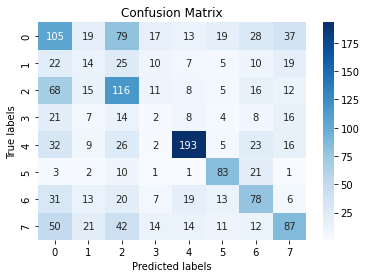

In [28]:
ax= plt.subplot()
cm = confusion_matrix(xgb_model.predict( X_test_text_vec2), y_test2)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [29]:
print(classification_report(xgb_model.predict( X_test_text_vec2), y_test2))

                       precision    recall  f1-score   support

 classic pop and rock       0.32      0.33      0.32       317
dance and electronica       0.14      0.12      0.13       112
                 folk       0.35      0.46      0.40       251
       jazz and blues       0.03      0.03      0.03        80
                metal       0.73      0.63      0.68       306
                  pop       0.57      0.68      0.62       122
                 punk       0.40      0.42      0.41       187
      soul and reggae       0.45      0.35      0.39       251

             accuracy                           0.42      1626
            macro avg       0.37      0.38      0.37      1626
         weighted avg       0.42      0.42      0.42      1626



In [30]:
print(cohen_kappa_score(xgb_model.predict(X_test_text_vec2), y_test2))

0.31657227375628816


In [31]:
pd.DataFrame(xgb_model.predict(X_valid_vecs),columns=['pred']).to_csv('test/valid_test_prediction.csv')